# Data Cleaning, Harmonization, and Exploratory Data Analysis

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Import libraries

In [2]:
# standard library
from concurrent import futures
import logging
import multiprocessing as mp
from pathlib import Path
from typing import Callable, Optional, Sequence, Tuple, Iterable, List, Dict, Any

# third-party libraries
import colorcet as cc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import SaltRemover, Descriptors, rdMolDescriptors, rdFingerprintGenerator, DataStructs
from scipy import stats
from tqdm.auto import tqdm

# local libraries
from admet.data.chem import (
    parallel_canonicalize_smiles,
    compute_molecular_properties,
)
from admet.data.constants import (
    TRANSFORMATIONS,
    COLS_WITH_UNITS,
)
from admet.visualize.plots import (
    plot_numeric_distributions,
    plot_correlation_matrix,
    plot_property_distributions,
)

In [3]:
%matplotlib inline

In [4]:
# setup tqdm
tqdm.pandas()

In [5]:
# setup logging
level = logging.DEBUG
logger = logging.getLogger(__name__)
if logger.hasHandlers():
    logger.handlers.clear()

formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel(level)

logger.info("Imports successful.")


2025-11-26 08:24:15,756 - __main__ - INFO - Imports successful.


## Load Data

In [6]:
cleaned_data = {}

In [7]:
# project data root directory
base_data_dir = Path().cwd().parents[0] / "assets/dataset/raw"
output_dir = base_data_dir.parents[0] / "eda"
output_dir.mkdir(parents=True, exist_ok=True)

if not base_data_dir.exists():
    raise FileNotFoundError(f"Data directory not found at {base_data_dir}")

logger.info(f"Data directory found at {base_data_dir}")
for dataset_dir in base_data_dir.iterdir():
    logger.info(f"Dataset name: {dataset_dir.name}")

2025-11-26 08:24:15,788 - __main__ - INFO - Data directory found at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/raw
2025-11-26 08:24:15,788 - __main__ - INFO - Dataset name: NCATS
2025-11-26 08:24:15,788 - __main__ - INFO - Dataset name: admetica
2025-11-26 08:24:15,789 - __main__ - INFO - Dataset name: Polaris-Antiviral
2025-11-26 08:24:15,789 - __main__ - INFO - Dataset name: TDC
2025-11-26 08:24:15,789 - __main__ - INFO - Dataset name: Polaris-Biogen
2025-11-26 08:24:15,789 - __main__ - INFO - Dataset name: ExpansionRX
2025-11-26 08:24:15,790 - __main__ - INFO - Dataset name: KERMT
2025-11-26 08:24:15,790 - __main__ - INFO - Dataset name: PharmaBench
2025-11-26 08:24:15,790 - __main__ - INFO - Dataset name: ChEMBL


### Challenge Data: ExpansionRX

In [8]:
# load data
data_path = base_data_dir / "ExpansionRX/full/expansion_data_train.csv"
df_expansionrx = pd.read_csv(data_path)

# rename cols to have units
df_expansionrx.rename(
    columns={k: f"{k} {v}" for k, v in COLS_WITH_UNITS.items() if k in df_expansionrx.columns},
    inplace=True,
)

# drop rows with invalid SMILES
df_expansionrx["SMILES"] = parallel_canonicalize_smiles(
    df_expansionrx["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_expansionrx["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_expansionrx.dropna(subset=["SMILES"], inplace=True)
    df_expansionrx.reset_index(drop=True, inplace=True)

logger.info(f"Dataframe shape: {df_expansionrx.shape}")
logger.info(f"Dataframe columns: {df_expansionrx.columns.tolist()}")

# log10 transform all targets except LogD
for col in df_expansionrx.columns:
    if col in ["LogD (None)", "SMILES", "Molecule Name (None)"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_expansionrx[col] = df_expansionrx[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")


Canonicalizing SMILES:   0%|          | 0/5326 [00:00<?, ?it/s]

2025-11-26 08:24:17,411 - __main__ - INFO - Dataframe shape: (5326, 11)
2025-11-26 08:24:17,411 - __main__ - INFO - Dataframe columns: ['Molecule Name (None)', 'SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)', 'MPPB (% unbound)', 'MBPB (% unbound)', 'MGMB (% unbound)']
2025-11-26 08:24:17,412 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-26 08:24:17,416 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-26 08:24:17,416 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-26 08:24:17,420 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-26 08:24:17,420 - __main__ - INFO - Log10 transforming column: MLM CLint (mL/min/kg)
2025-11-26 08:24:17,424 - __main__ - INFO - Transformed column: MLM CLint (mL/min/kg) with log10
2025-11-26 08:24:17,424 - __main__ - INFO - Log10 transforming c

In [9]:
df_expansionrx.sort_values("Molecule Name (None)", inplace=True)
df_expansionrx.reset_index(drop=True, inplace=True)

df_expansionrx

,Molecule Name (None),SMILES,LogD (None),KSOL (uM),HLM CLint (mL/min/kg),MLM CLint (mL/min/kg),Caco-2 Permeability Papp A>B (10^-6 cm/s),Caco-2 Permeability Efflux (None),MPPB (% unbound),MBPB (% unbound),MGMB (% unbound)
0,E-0001321,CN1CCC[C@H]1COc1ccc(-c2nc3cc(-c4ccc5[nH]c(-c6c...,NaN,NaN,1.751279,2.260787,NaN,NaN,NaN,NaN,NaN
1,E-0001780,COc1ccc2c(c1)c1cc3cnccc3c(C)c1n2C,NaN,NaN,2.205204,3.130687,NaN,NaN,NaN,NaN,NaN
2,E-0001827,Cc1c2ccncc2cc2c3cc(OCCCN4CCN(C)CC4)ccc3n(C)c12,NaN,NaN,NaN,2.286681,NaN,NaN,NaN,NaN,NaN
3,E-0002019,CN(C)CCCOc1ccc(-c2nc3cc(NC(=O)c4ccc5[nH]c(-c6c...,NaN,NaN,0.977724,NaN,NaN,NaN,NaN,NaN,NaN
4,E-0002036,CN(C)CCCOc1ccc2nc(-c3ccc(-c4nc5ccc(OCCCN(C)C)c...,NaN,NaN,NaN,2.209515,NaN,NaN,NaN,NaN,-1.913605
...,...,...,...,...,...,...,...,...,...,...,...
5321,E-0020096,CCn1c(C(=O)N2CCN(c3ccncc3)CC2)cc2cc(-c3nnc(C4C...,2.5,2.409933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5322,E-0020097,Cc1nnc(-c2cnc3c(c2)cc(C(=O)N2CCCN(c4ccncc4C)CC...,1.5,2.442480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5323,E-0020098,Cc1nnc(-c2ccc3c(c2)cc(C(=O)N2CCCN(c4ccncc4)CC2...,1.0,2.436163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5324,E-0020099,Cc1nnc(-c2ccc3c(c2)cc(C(=O)N2CCCN(c4ccncc4C)CC...,2.2,2.436163,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
missing_val = df_expansionrx.iloc[0]["LogD (None)"]

2025-11-26 08:24:17,749 - __main__ - INFO - Column: HLM CLint (mL/min/kg) | Total values: 5326 | Negative values: 164 | Fraction negative: 0.0308 | Distinct values: 1
2025-11-26 08:24:17,853 - __main__ - INFO - Column: MLM CLint (mL/min/kg) | Total values: 5326 | Negative values: 147 | Fraction negative: 0.0276 | Distinct values: 1
2025-11-26 08:24:17,870 - __main__ - INFO - Column: MPPB (% unbound) | Total values: 5326 | Negative values: 10 | Fraction negative: 0.0019 | Distinct values: 1
2025-11-26 08:24:17,887 - __main__ - INFO - Column: MBPB (% unbound) | Total values: 5326 | Negative values: 2 | Fraction negative: 0.0004 | Distinct values: 1
2025-11-26 08:24:17,904 - __main__ - INFO - Column: MGMB (% unbound) | Total values: 5326 | Negative values: 1 | Fraction negative: 0.0002 | Distinct values: 1
2025-11-26 08:24:17,920 - __main__ - WARNING - Column Molecule Name (None) not in cutoff columns, skipping.
2025-11-26 08:24:17,920 - __main__ - WARNING - Column SMILES not in cutoff co

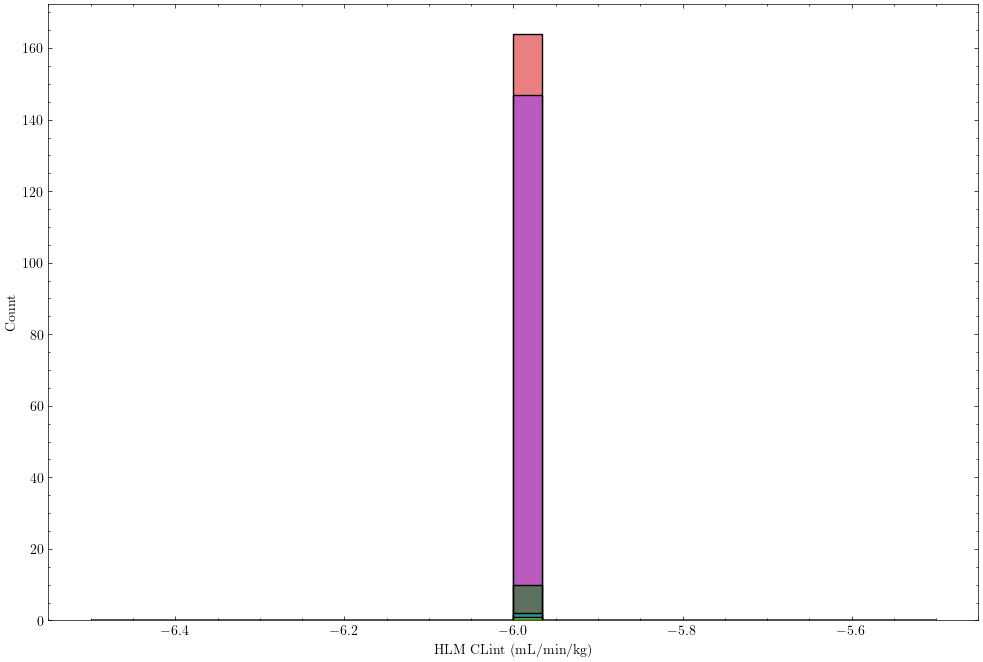

In [11]:
# For {MPPB, MBPB, MGMB} compute number of values < 0, their fraction, and distint values
BINDING_CUTOFF = -3.0
cutoff_columns = ["MPPB", "MBPB", "MGMB", "HLM CLint", "MLM CLint"]
df_expansionrx_filtered = df_expansionrx.copy()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

for col in df_expansionrx.columns:
    if any(x in col for x in cutoff_columns):
        n_values = df_expansionrx.shape[0]
        sub_series = df_expansionrx[col].dropna()
        sub_series = sub_series[sub_series < BINDING_CUTOFF]
        
        n_negative = sub_series.shape[0]
        fraction_negative = n_negative / n_values if n_values > 0 else 0.0
        n_distinct = sub_series.nunique()
        logger.info(
            f"Column: {col} | Total values: {n_values} | Negative values: {n_negative} | "
            f"Fraction negative: {fraction_negative:.4f} | Distinct values: {n_distinct}"
        )
        
        sns.histplot(sub_series, bins=30, kde=True, ax=ax, label=col, alpha=0.5)

# REVIEW: replace with np.nan
for col in df_expansionrx.columns:
    if any(x in col for x in cutoff_columns):
        sub_series = df_expansionrx[col].dropna()
        idx_to_drop = sub_series[sub_series < BINDING_CUTOFF].index.tolist()
        if len(idx_to_drop) > 0:
            logger.info(f"Setting {len(idx_to_drop)} values in column {col} below cutoff to NaN")
            percentage_to_nan = len(idx_to_drop) / sub_series.shape[0] * 100
            logger.debug(f"Percentage of data in column {col} being set to NaN: {percentage_to_nan:.4f}%")
        df_expansionrx_filtered.loc[idx_to_drop, col] = missing_val
    else:
        logger.warning(f"Column {col} not in cutoff columns, skipping.")

In [12]:
cleaned_data["expansionrx"] = df_expansionrx_filtered.copy()

df = df_expansionrx_filtered.copy()
df_props = compute_molecular_properties(df["SMILES"])
logger.info(f"Molecular properties computed for {df_props.shape[0]} molecules and {df_props.shape[1]} properties.")
logger.debug(f"Molecular properties: {df_props.columns.tolist()}")


2025-11-26 08:24:20,349 - __main__ - INFO - Molecular properties computed for 5326 molecules and 9 properties.
2025-11-26 08:24:20,349 - __main__ - DEBUG - Molecular properties: ['SMILES', 'MW', 'TPSA', 'HBA', 'HBD', 'RotBonds', 'LogP', 'NumHeavyAtoms', 'NumRings']


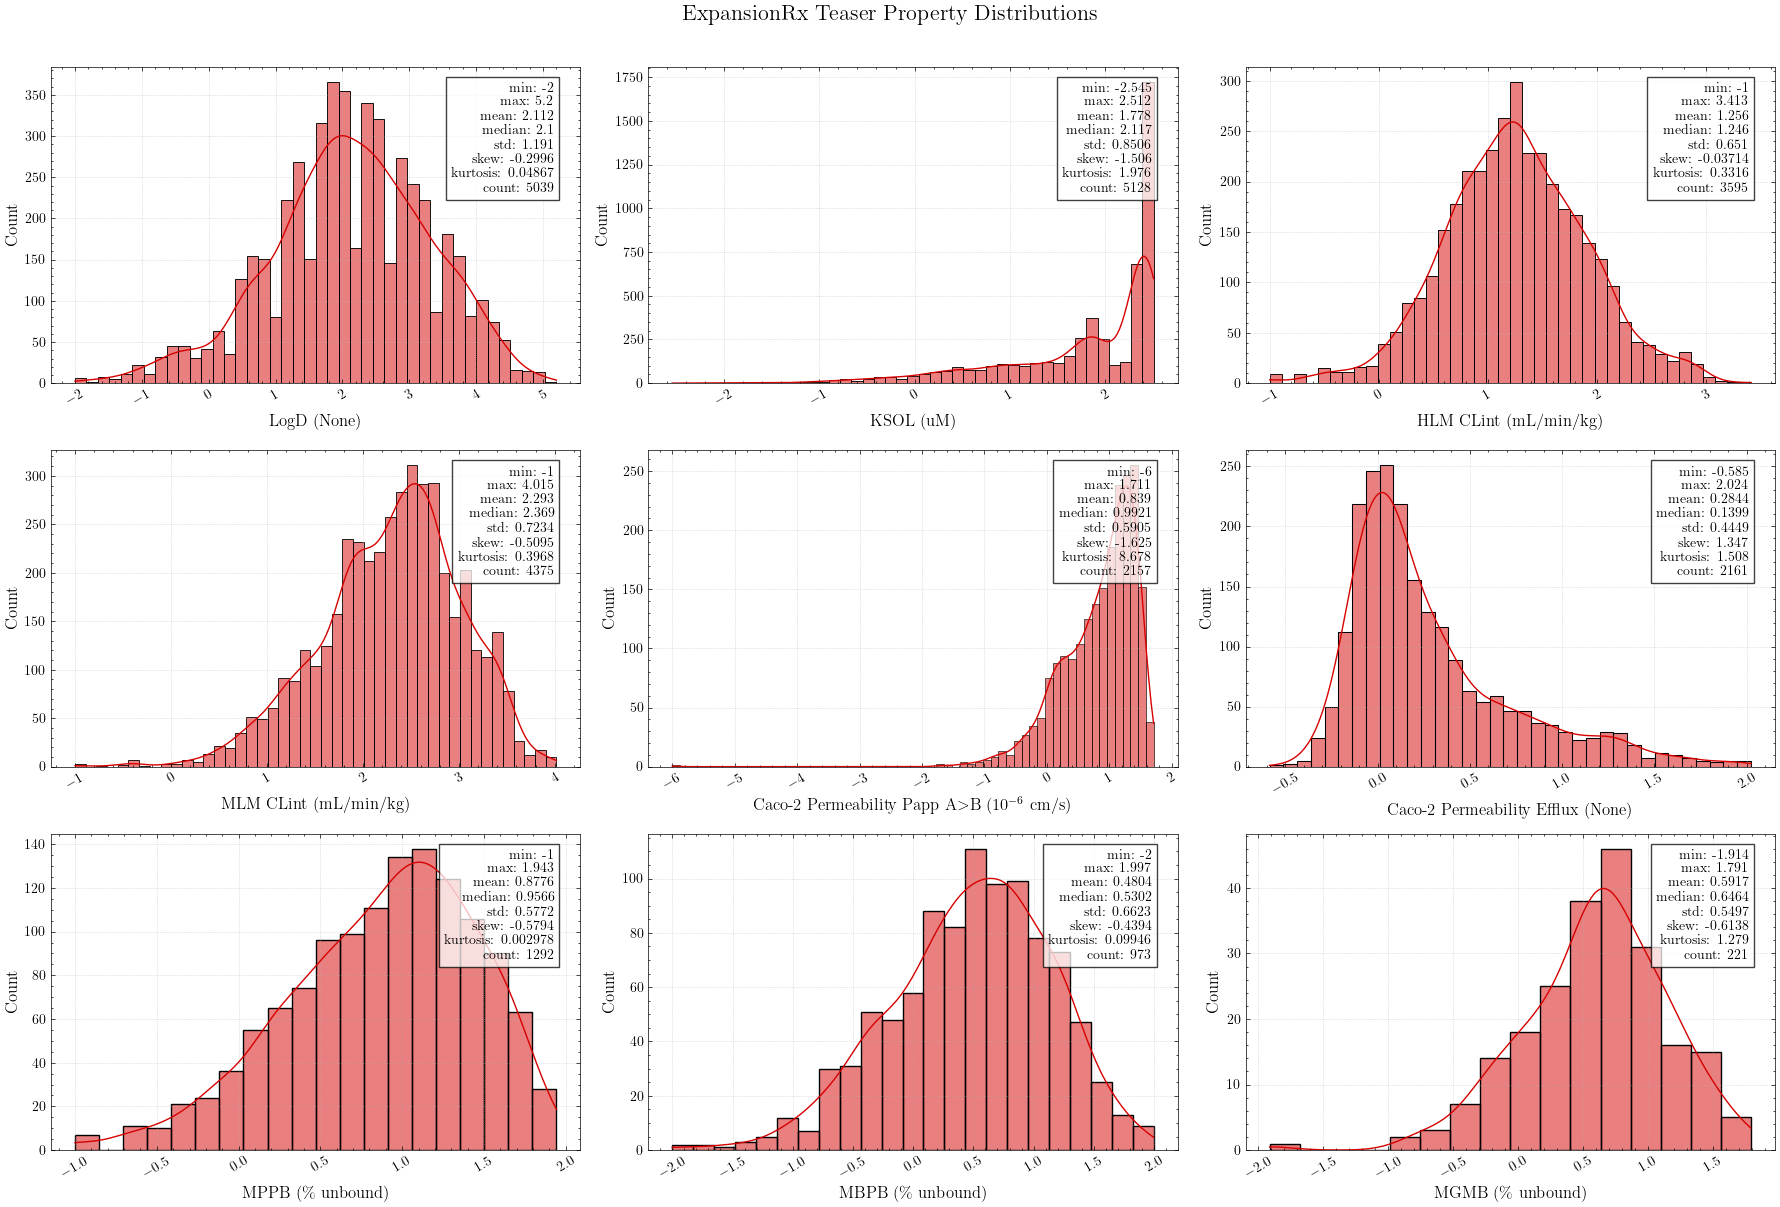

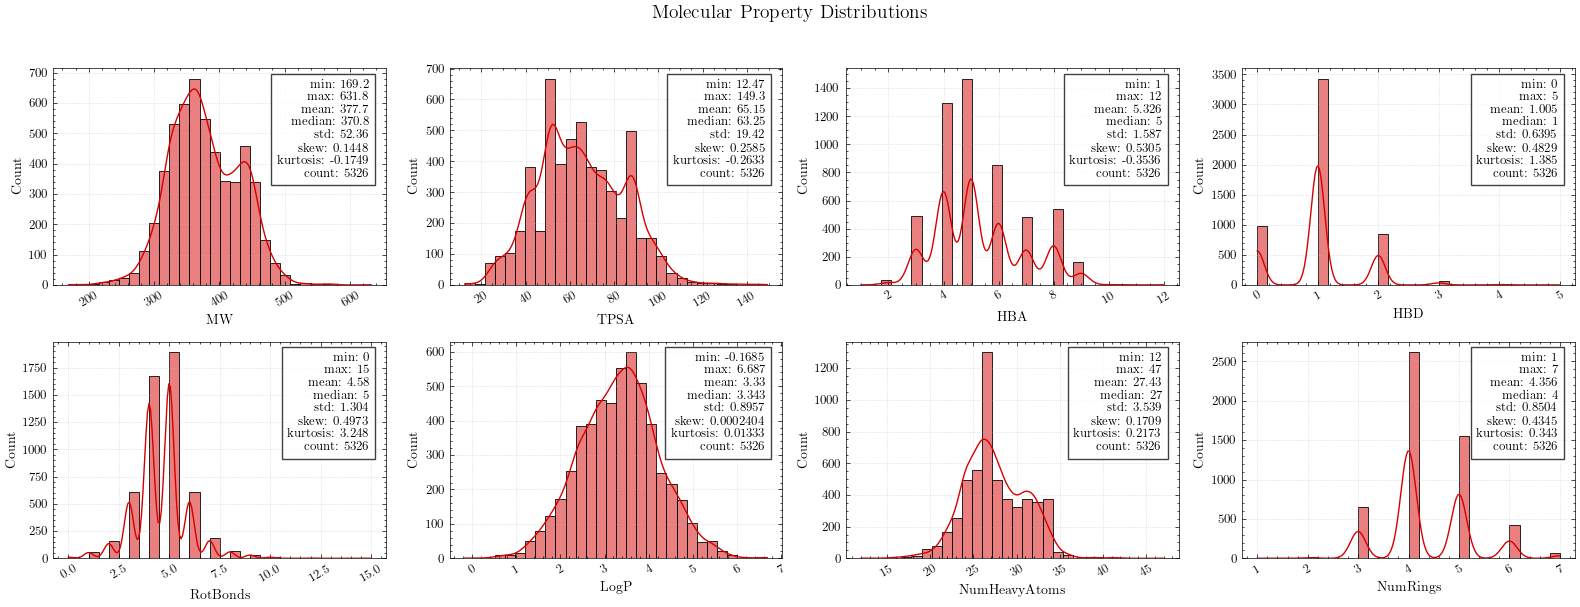

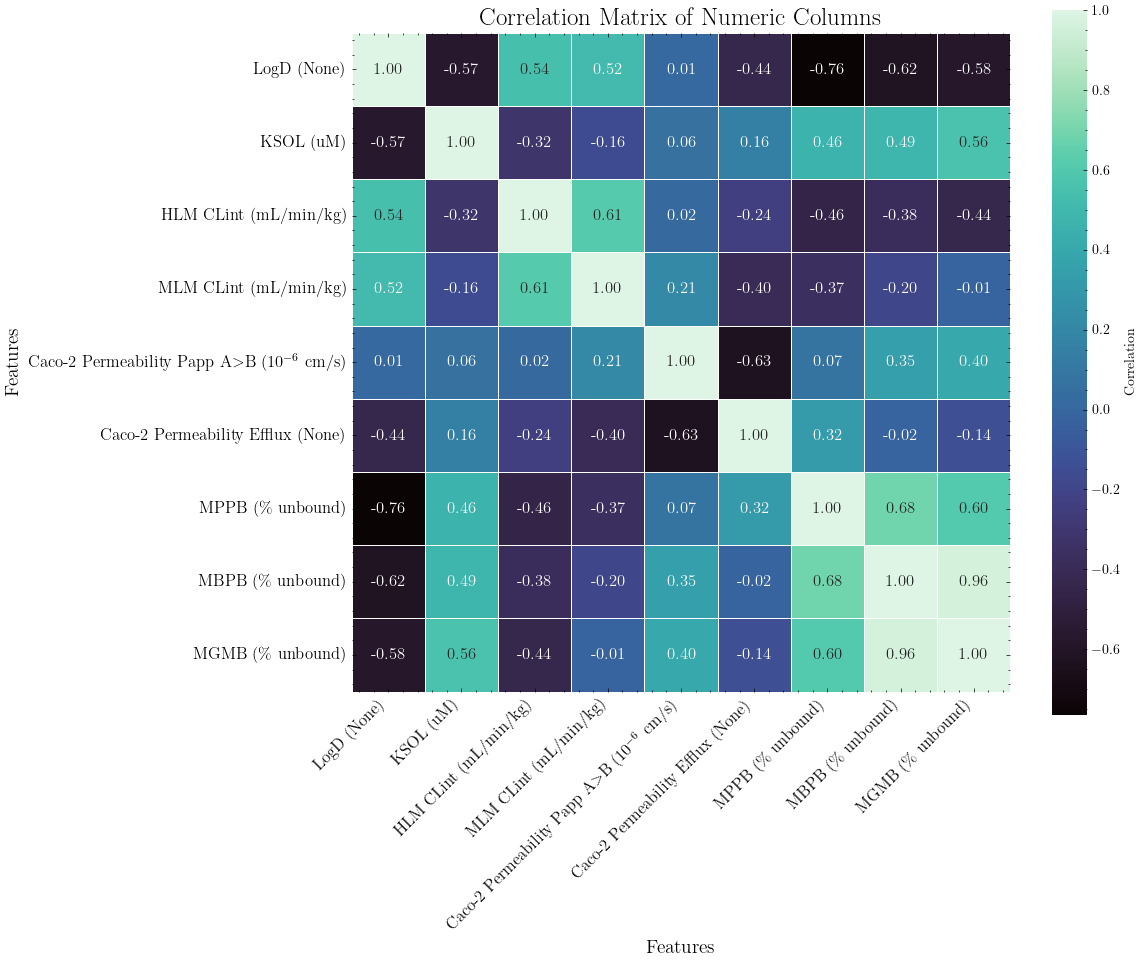

In [13]:
fname = "expansionrx"
output_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plot_numeric_distributions(
    df,
    n_cols=3,
    title="ExpansionRx Teaser Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

### KERMT Dataset

#### Public

Key dataset information

In [14]:
files_biogen = [
    "KERMT/export_public_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

# map from KERMT data to ExpansionRX data on SMILES
map_cols_kermt_to_expansionrx = [
    {
        "input_col": "LogD_pH_7.4",  # NOTE: pH 7.4
        "output_col": "LogD (None)",
        "transform": TRANSFORMATIONS["None"],
    },
    {
        "input_col": "kinetic_logSaq",  # log(M)
        "output_col": "KSOL (uM)",
        "transform": TRANSFORMATIONS["10^(x+6)"],
    },
    {
        "input_col": "CL_microsome_human",  # log(mL/min/kg)
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": TRANSFORMATIONS["10^(x); 1/kg to 1/g"],
    },
    {
        "input_col": "CL_microsome_mouse",  # log(mL/min/kg)
        "output_col": "MLM CLint (mL/min/kg)",
        "transform": TRANSFORMATIONS["10^(x); 1/kg to 1/g"],
    },
    {
        "input_col": "Papp_Caco2",  # log(10^-6 cm/sec)
        "output_col": "Caco-2 Permeability Papp A>B (10^-6 cm/s)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
    {
        "input_col": "Rat_fraction_unbound_plasma",  # log(% Unbound)
        "output_col": "MPPB (% unbound)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
    {
        # REVIEW: low confidence mapping
        "input_col": "Pgp_human",  # log(None)
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
]

Load and concatenate public KERMT files. Drop duplicates and bad data.

In [15]:
df_kermt_public = pd.DataFrame()
for f in files_biogen:
    df = pd.read_csv(base_data_dir / f)
    df["file"] = f
    df_kermt_public = pd.concat([df_kermt_public, df], ignore_index=True)

# rename smiles --> SMILES
df_kermt_public.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_public["SMILES"] = parallel_canonicalize_smiles(
    df_kermt_public["SMILES"].tolist(),
    isomeric=True,
)
n_none_smiles = df_kermt_public["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_public.dropna(subset=["SMILES"], inplace=True)
    df_kermt_public.reset_index(drop=True, inplace=True)

logger.info(f"KERMT Public Dataframe shape: {df_kermt_public.shape}")
logger.info(f"KERMT Public Dataframe columns: {df_kermt_public.columns.tolist()}")

# print finite number of entries for each column
for col in df_kermt_public.columns:
    if not pd.api.types.is_numeric_dtype(df_kermt_public[col]):
        continue
    n_finite = np.isfinite(df_kermt_public[col]).sum()
    logger.info(f"Column '{col}' has {n_finite} finite entries out of {len(df_kermt_public)}")

Canonicalizing SMILES:   0%|          | 0/114112 [00:00<?, ?it/s]

2025-11-26 08:24:58,402 - __main__ - INFO - KERMT Public Dataframe shape: (114112, 27)
2025-11-26 08:24:58,402 - __main__ - INFO - KERMT Public Dataframe columns: ['SMILES', 'CL_microsome_human', 'CL_microsome_mouse', 'CL_microsome_rat', 'CL_total_dog', 'CL_total_human', 'CL_total_monkey', 'CL_total_rat', 'CYP2C8_inhibition', 'CYP2C9_inhibition', 'CYP2D6_inhibition', 'CYP3A4_inhibition', 'Dog_fraction_unbound_plasma', 'Human_fraction_unbound_plasma', 'Monkey_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'Papp_Caco2', 'Pgp_human', 'hERG_binding', 'LogD_pH_7.4', 'kinetic_logSaq', 'thermo_logSaq', 'VDss_dog', 'VDss_human', 'VDss_monkey', 'VDss_rat', 'file']
2025-11-26 08:24:58,403 - __main__ - INFO - Column 'CL_microsome_human' has 5218 finite entries out of 114112
2025-11-26 08:24:58,403 - __main__ - INFO - Column 'CL_microsome_mouse' has 663 finite entries out of 114112
2025-11-26 08:24:58,403 - __main__ - INFO - Column 'CL_microsome_rat' has 1798 finite entries out of 114112

Transform dataset column names to be compatible with ExpansionRX dataset.

In [16]:
df_kermt_public_admet_cleaned = df_kermt_public[["SMILES"]]
for mapping in map_cols_kermt_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_public[["SMILES", input_col]].copy()
    df_input[output_col] = df_input[input_col].apply(transform).copy()
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_public_admet_cleaned = pd.merge(df_kermt_public_admet_cleaned, df_input, on="SMILES")

# log10 transform all targets except LogD
for col in df_kermt_public_admet_cleaned.columns:
    if col in ["LogD (None)", "SMILES"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_kermt_public_admet_cleaned[col] = df_kermt_public_admet_cleaned[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")

2025-11-26 08:24:59,227 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-26 08:24:59,312 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-26 08:24:59,312 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-26 08:24:59,395 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-26 08:24:59,395 - __main__ - INFO - Log10 transforming column: MLM CLint (mL/min/kg)
2025-11-26 08:24:59,479 - __main__ - INFO - Transformed column: MLM CLint (mL/min/kg) with log10
2025-11-26 08:24:59,480 - __main__ - INFO - Log10 transforming column: Caco-2 Permeability Papp A>B (10^-6 cm/s)
2025-11-26 08:24:59,563 - __main__ - INFO - Transformed column: Caco-2 Permeability Papp A>B (10^-6 cm/s) with log10
2025-11-26 08:24:59,564 - __main__ - INFO - Log10 transforming column: MPPB (% unbound)
2025-11-26 08:24:59,647 - __main__ - INFO - Transformed column: MPPB (% unbound) with log10
2025-11-26 08:24:59,647 - __main__ - INFO - 

In [17]:
# check for repeated SMILES
n_total = len(df_kermt_public_admet_cleaned)
n_unique = df_kermt_public_admet_cleaned["SMILES"].nunique()
n_duplicates = n_total - n_unique
if n_duplicates > 0:
    logger.warning(f"Found {n_duplicates} duplicate SMILES in merged KERMT-ExpansionRX dataframe")
    # average (skip NaNs) over duplicates
    df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned.groupby("SMILES", as_index=False).mean()
    logger.info(f"Dataframe shape after averaging duplicates: {df_kermt_public_admet_cleaned.shape}")

# check for overlap with ExpansionRx teaser dataset
smiles_teaser = set(df_expansionrx["SMILES"].tolist())
smiles_kermt_expansionrx = set(df_kermt_public_admet_cleaned["SMILES"].tolist())
overlap_smiles = smiles_teaser.intersection(smiles_kermt_expansionrx)
n_overlap = len(overlap_smiles)
if n_overlap > 0:
    logger.warning(f"Found {n_overlap} overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets")

2025-11-26 08:24:59,801 - __main__ - WARNING - Found 11985 duplicate SMILES in merged KERMT-ExpansionRX dataframe
2025-11-26 08:24:59,885 - __main__ - INFO - Dataframe shape after averaging duplicates: (114065, 8)
2025-11-26 08:24:59,892 - __main__ - WARNING - Found 2 overlapping SMILES between ExpansionRx teaser and KERMT-ExpansionRX datasets


In [18]:
# print num non-nan entries for each column
for col in df_kermt_public_admet_cleaned.columns:
    if col == "SMILES":
        continue
    n_non_nan = df_kermt_public_admet_cleaned[col].notna().sum()
    logger.info(f"Column '{col}' has {n_non_nan} non-NaN entries out of {len(df_kermt_public_admet_cleaned)}")

2025-11-26 08:24:59,959 - __main__ - INFO - Column 'LogD (None)' has 4190 non-NaN entries out of 114065
2025-11-26 08:24:59,959 - __main__ - INFO - Column 'KSOL (uM)' has 74895 non-NaN entries out of 114065
2025-11-26 08:24:59,960 - __main__ - INFO - Column 'HLM CLint (mL/min/kg)' has 5218 non-NaN entries out of 114065
2025-11-26 08:24:59,961 - __main__ - INFO - Column 'MLM CLint (mL/min/kg)' has 663 non-NaN entries out of 114065
2025-11-26 08:24:59,961 - __main__ - INFO - Column 'Caco-2 Permeability Papp A>B (10^-6 cm/s)' has 6457 non-NaN entries out of 114065
2025-11-26 08:24:59,961 - __main__ - INFO - Column 'MPPB (% unbound)' has 237 non-NaN entries out of 114065
2025-11-26 08:24:59,962 - __main__ - INFO - Column 'Caco-2 Permeability Efflux (None)' has 2073 non-NaN entries out of 114065


In [19]:
cleaned_data["kermt_public"] = df_kermt_public_admet_cleaned.copy()

Visualize distributions of dataset

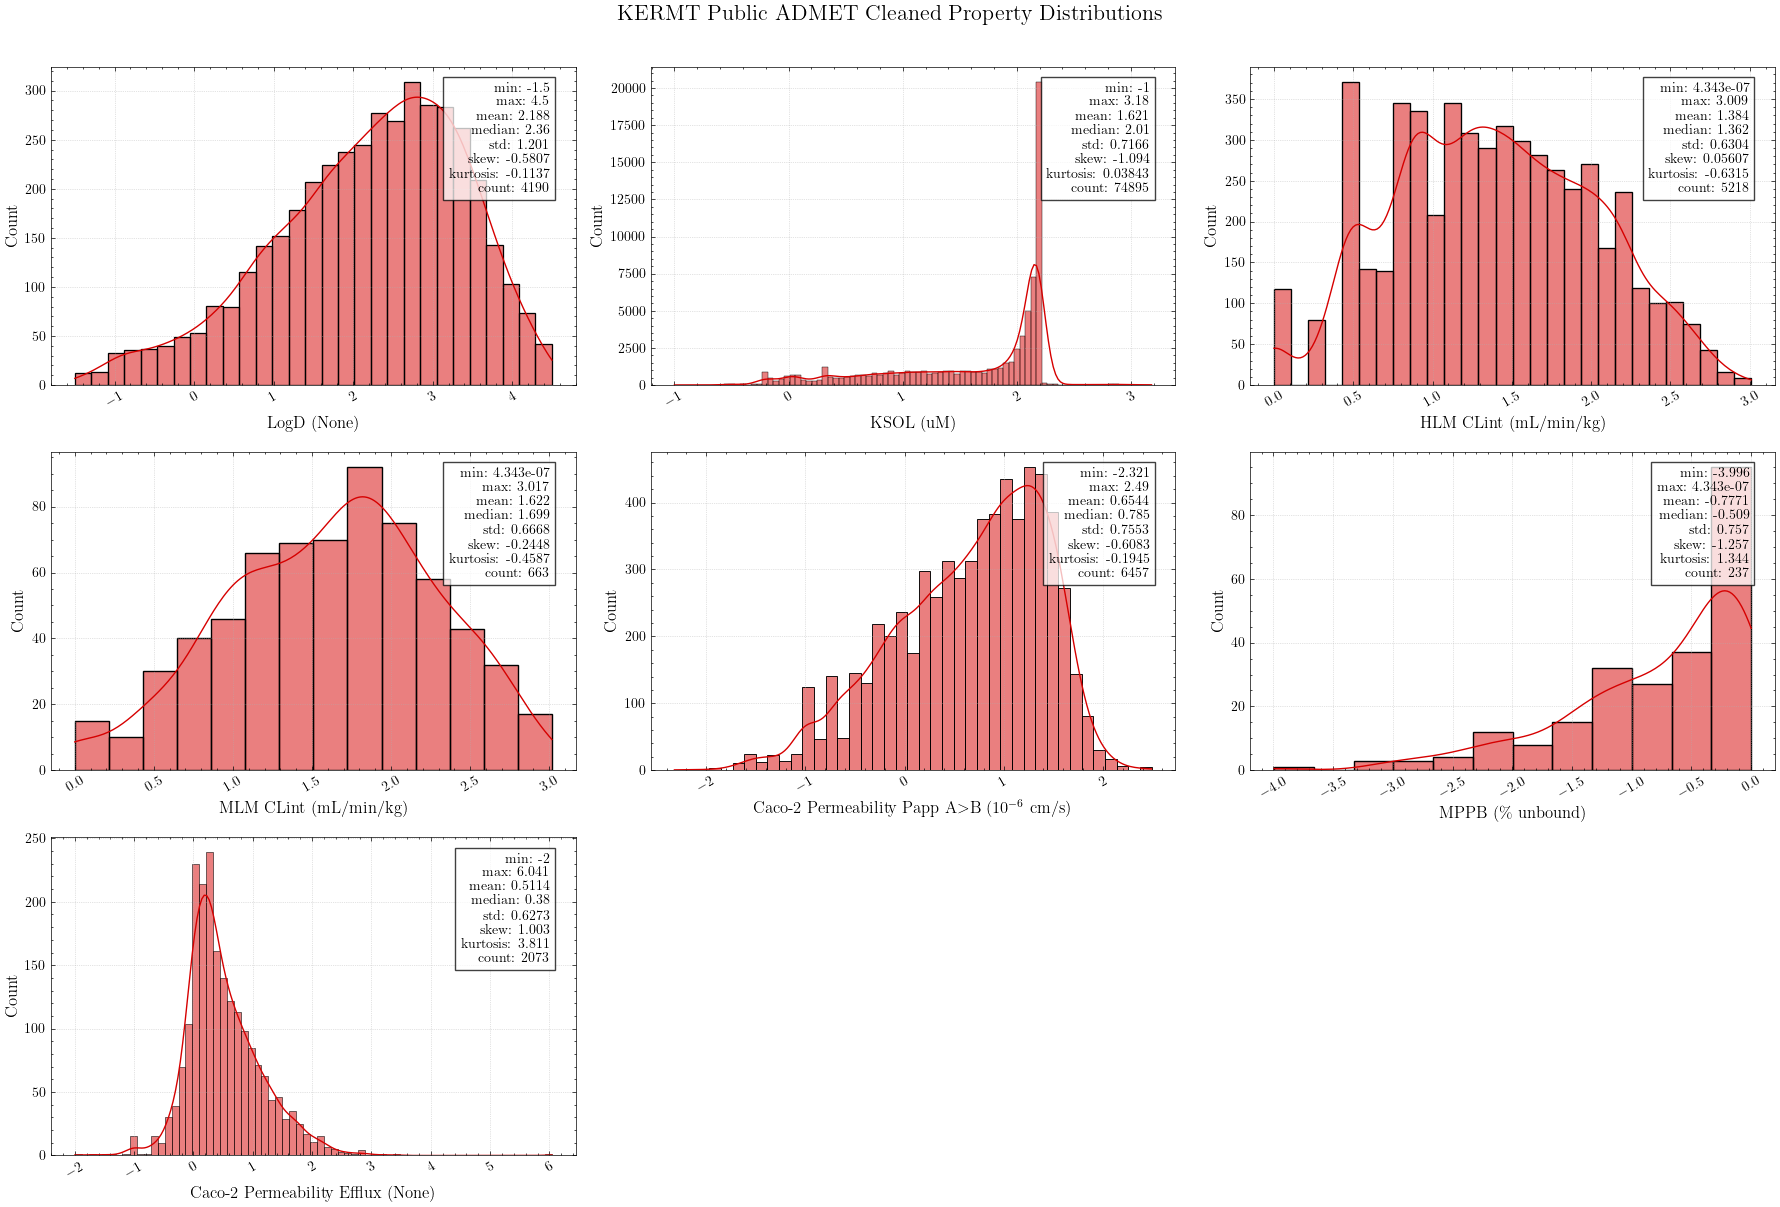

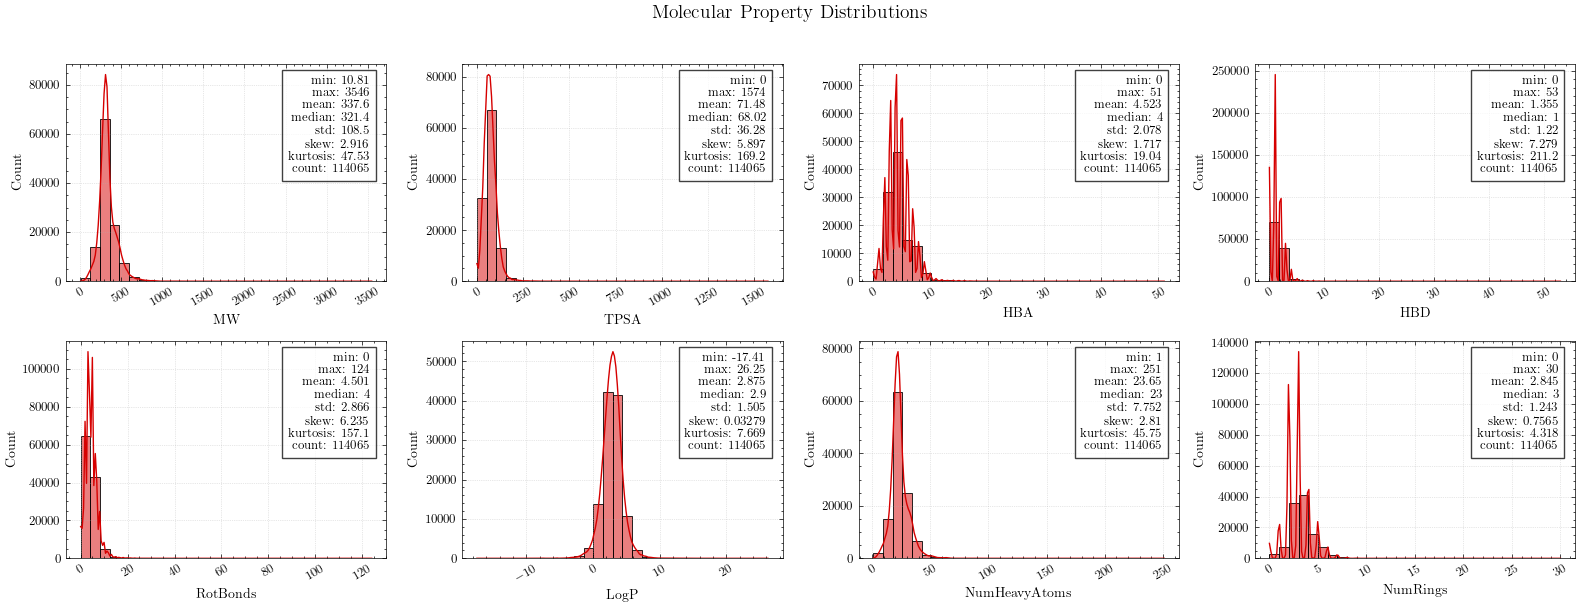

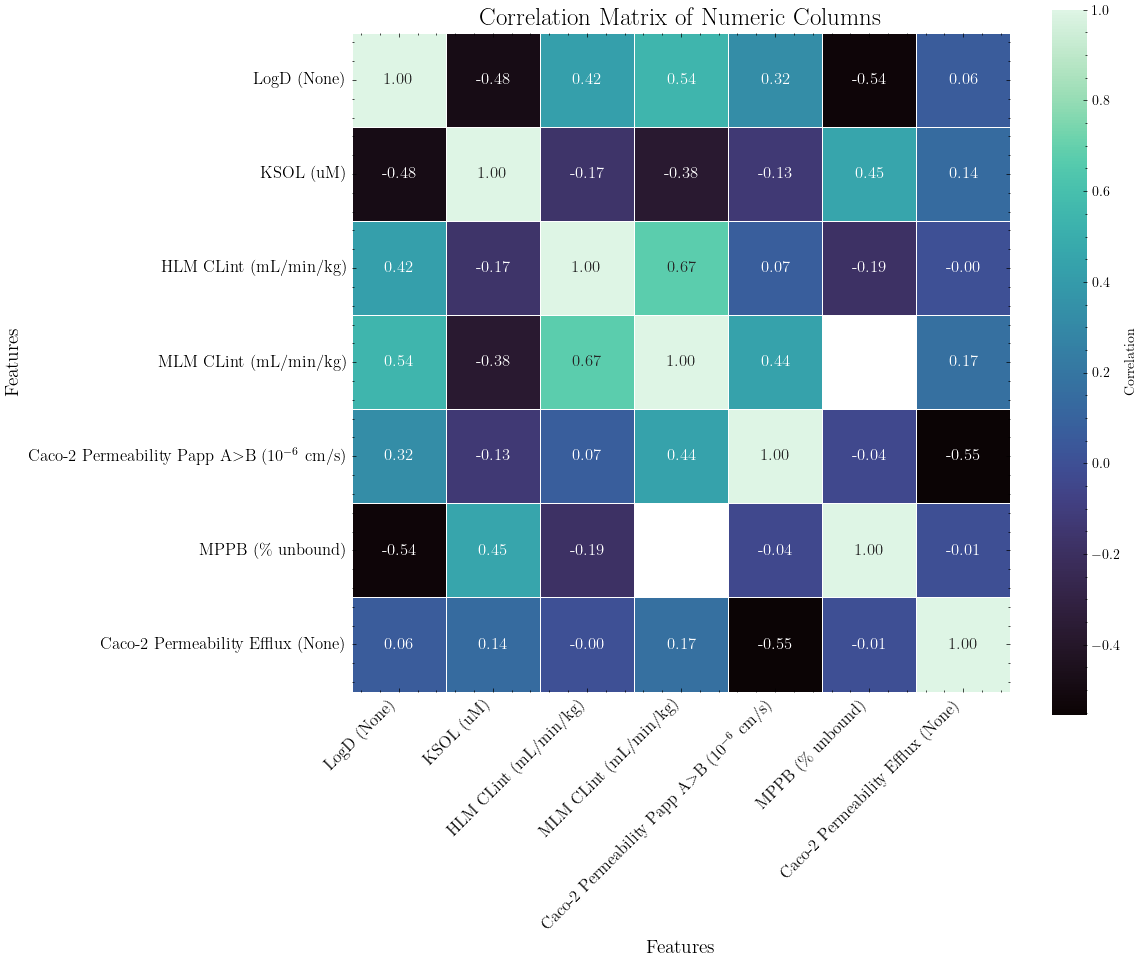

In [20]:
df = df_kermt_public_admet_cleaned.copy()
fname = "kermt_public_admet_cleaned"

df_props = compute_molecular_properties(df["SMILES"])
output_dir.mkdir(parents=True, exist_ok=True)
fig, ax = plot_numeric_distributions(
    df,
    n_cols=3,
    title="KERMT Public ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

#### Biogen

In [21]:
files_biogen = [
    "KERMT/export_biogen_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

map_cols_biogen_to_expansionrx = [
    {
        "input_col": "SOLY_6.8",  # NOTE: This is not pH 7
        "output_col": "KSOL (uM)",
        "transform": TRANSFORMATIONS["ug/mL to uM"],
    },
    {
        "input_col": "MDR1-MDCK_ER",  # NOTE: MDCK not Caco-2
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": TRANSFORMATIONS["None"],
    },
    {
        "input_col": "HLM_CLint",
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
    {
        "input_col": "Rat_fraction_unbound_plasma",  # log(% Unbound)
        "output_col": "MPPB (% unbound)",
        "transform": TRANSFORMATIONS["10^(x)"],
    },
]

In [22]:
# load and concatenate biogen files
df_kermt_biogen = [pd.read_csv(base_data_dir / file) for file in files_biogen]
df_kermt_biogen = pd.concat(df_kermt_biogen, ignore_index=True)
logger.info(f"KERMT Biogen Dataframe shape: {df_kermt_biogen.shape}")
logger.info(f"KERMT Biogen Dataframe columns: {df_kermt_biogen.columns.tolist()}")

# rename smiles --> SMILES
df_kermt_biogen.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_biogen["SMILES"] = parallel_canonicalize_smiles(
    df_kermt_biogen["SMILES"].tolist(),
    isomeric=True,
)
df_kermt_biogen["MW"] = df_kermt_biogen["SMILES"].apply(lambda smi: Descriptors.MolWt(Chem.MolFromSmiles(smi)) if smi is not None else np.nan)

n_none_smiles = df_kermt_biogen["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_biogen.dropna(subset=["SMILES"], inplace=True)
    df_kermt_biogen.reset_index(drop=True, inplace=True)
logger.info(f"KERMT Biogen Dataframe shape after cleaning: {df_kermt_biogen.shape}")


2025-11-26 08:25:48,876 - __main__ - INFO - KERMT Biogen Dataframe shape: (3521, 7)
2025-11-26 08:25:48,876 - __main__ - INFO - KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']


Canonicalizing SMILES:   0%|          | 0/3521 [00:00<?, ?it/s]

2025-11-26 08:25:50,081 - __main__ - INFO - KERMT Biogen Dataframe shape after cleaning: (3521, 8)


In [23]:
# map to ExpansionRX columns
df_kermt_biogen_admet_cleaned = df_kermt_biogen[["SMILES"]]
for mapping in map_cols_biogen_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_biogen[["SMILES", input_col]].copy()
    if input_col == "SOLY_6.8":
        # need MW for conversion
        df_input = pd.merge(
            df_input,
            df_kermt_biogen[["SMILES", "MW"]],
            on="SMILES",
            how="left",
        )
        df_input[output_col] = df_input.apply(
            lambda row: transform(row[input_col], row["MW"]),
            axis=1,
        )
        df_input.drop(columns=["MW"], inplace=True)
    else:
        df_input[output_col] = df_input[input_col].apply(transform).copy()
        
    logger.info(f"Transformed column '{input_col}' to '{output_col}' with {len(df_input)} entries.")
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_biogen_admet_cleaned = pd.merge(df_kermt_biogen_admet_cleaned, df_input, on="SMILES")

2025-11-26 08:25:50,202 - __main__ - INFO - Transformed column 'SOLY_6.8' to 'KSOL (uM)' with 3521 entries.
2025-11-26 08:25:50,204 - __main__ - INFO - Transformed column 'MDR1-MDCK_ER' to 'Caco-2 Permeability Efflux (None)' with 3521 entries.
2025-11-26 08:25:50,209 - __main__ - INFO - Transformed column 'HLM_CLint' to 'HLM CLint (mL/min/kg)' with 3521 entries.
2025-11-26 08:25:50,214 - __main__ - INFO - Transformed column 'Rat_fraction_unbound_plasma' to 'MPPB (% unbound)' with 3521 entries.


In [24]:
# print num non-nan entries for each column
for col in df_kermt_biogen_admet_cleaned.columns:
    if col == "SMILES":
        continue
    n_non_nan = df_kermt_biogen_admet_cleaned[col].notna().sum()
    logger.info(f"Column '{col}' has {n_non_nan} non-NaN entries out of {len(df_kermt_biogen_admet_cleaned)}")

2025-11-26 08:25:50,270 - __main__ - INFO - Column 'KSOL (uM)' has 2173 non-NaN entries out of 3521
2025-11-26 08:25:50,270 - __main__ - INFO - Column 'Caco-2 Permeability Efflux (None)' has 2642 non-NaN entries out of 3521
2025-11-26 08:25:50,271 - __main__ - INFO - Column 'HLM CLint (mL/min/kg)' has 3087 non-NaN entries out of 3521
2025-11-26 08:25:50,271 - __main__ - INFO - Column 'MPPB (% unbound)' has 168 non-NaN entries out of 3521


In [25]:
# log10 transform all targets except LogD
for col in df_kermt_biogen_admet_cleaned.columns:
    if col in ["LogD (None)", "SMILES"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_kermt_biogen_admet_cleaned[col] = df_kermt_biogen_admet_cleaned[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")
        

2025-11-26 08:25:50,329 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-26 08:25:50,333 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-26 08:25:50,333 - __main__ - INFO - Log10 transforming column: Caco-2 Permeability Efflux (None)
2025-11-26 08:25:50,337 - __main__ - INFO - Transformed column: Caco-2 Permeability Efflux (None) with log10
2025-11-26 08:25:50,337 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-26 08:25:50,340 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-26 08:25:50,340 - __main__ - INFO - Log10 transforming column: MPPB (% unbound)
2025-11-26 08:25:50,343 - __main__ - INFO - Transformed column: MPPB (% unbound) with log10


In [26]:
# export data
logger.info(f"KERMT Biogen-ExpansionRX Dataframe shape: {df_kermt_biogen_admet_cleaned.shape}")
cleaned_data["kermt_biogen"] = df_kermt_biogen_admet_cleaned.copy()

2025-11-26 08:25:50,403 - __main__ - INFO - KERMT Biogen-ExpansionRX Dataframe shape: (3521, 5)


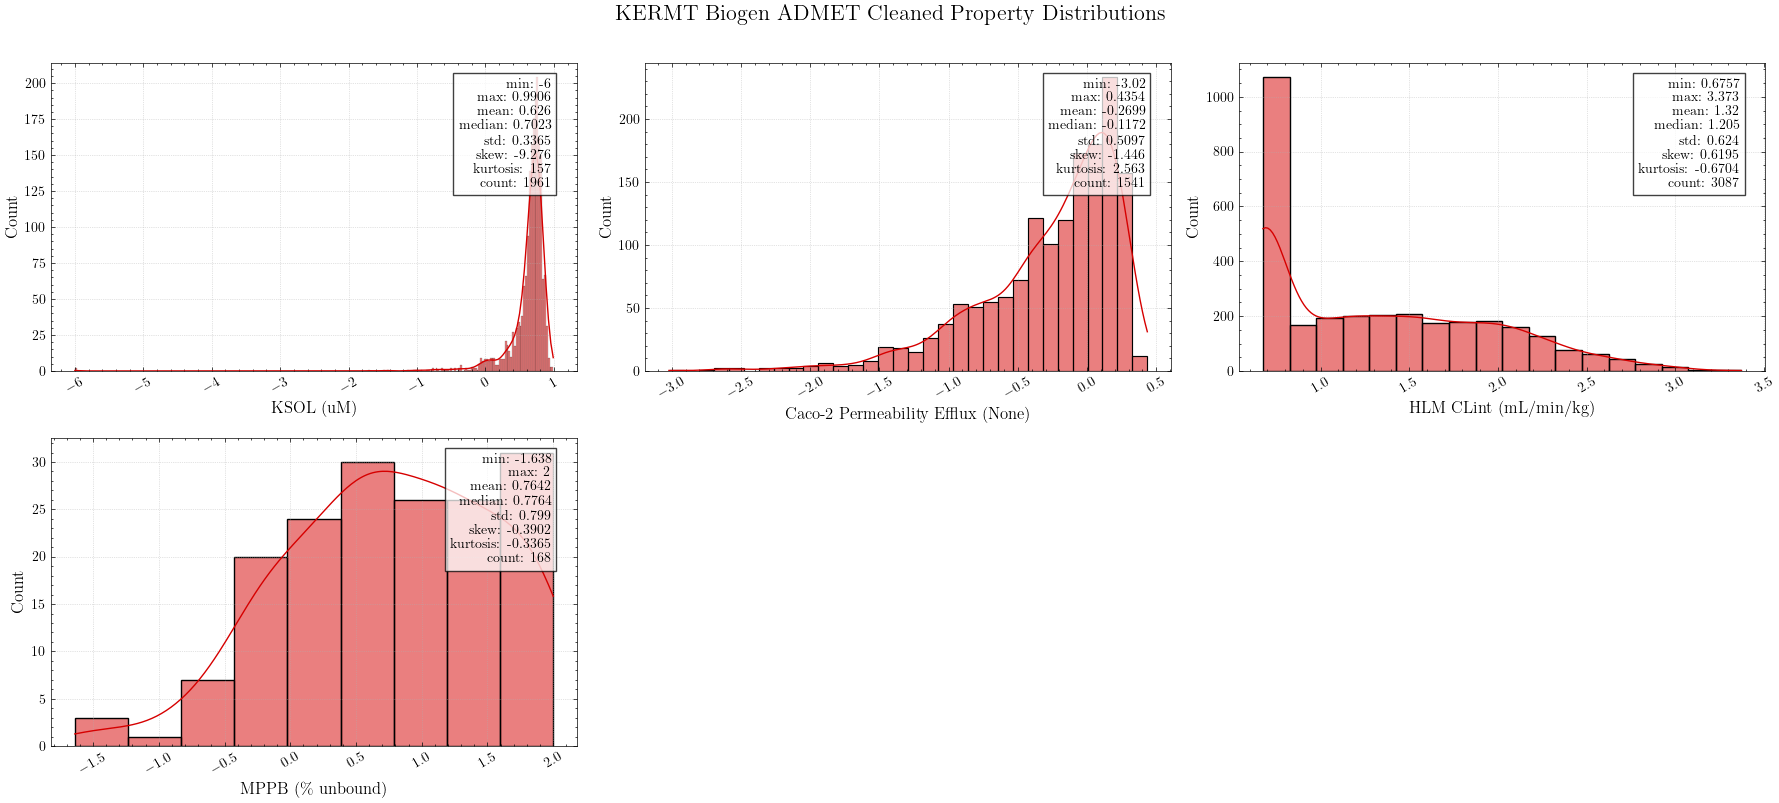

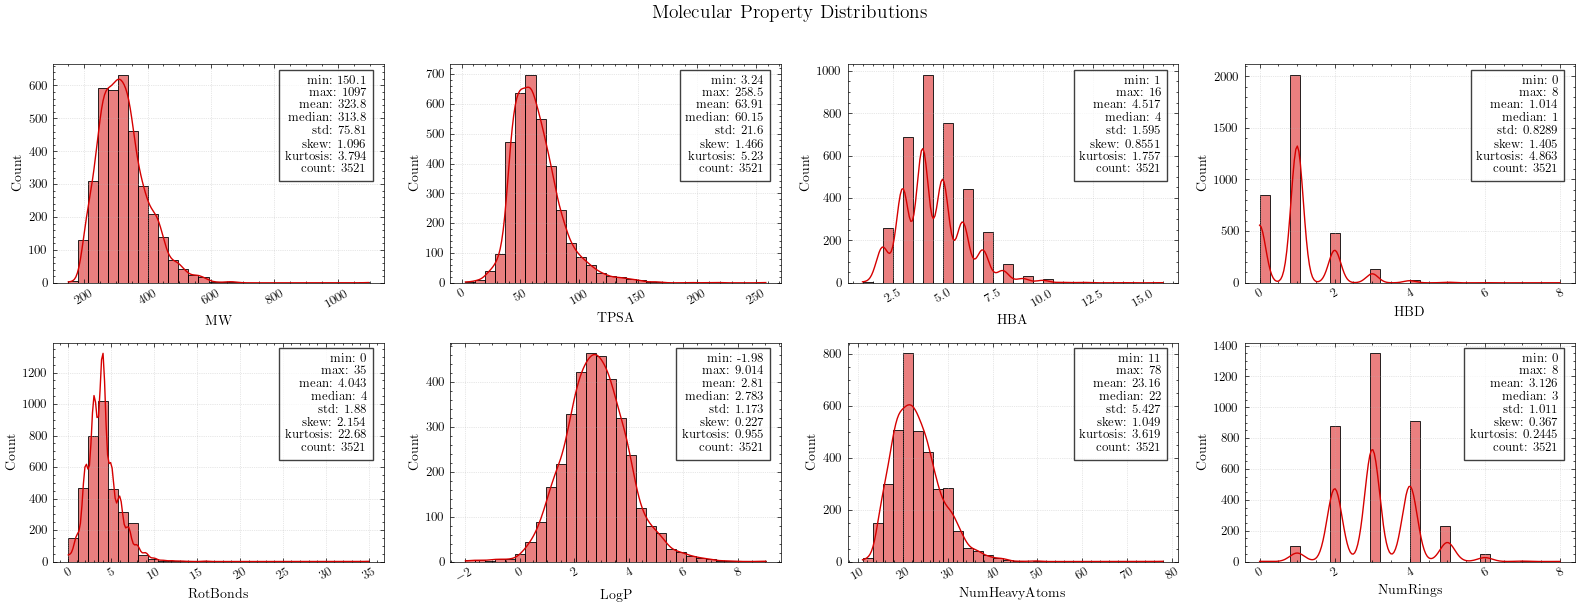

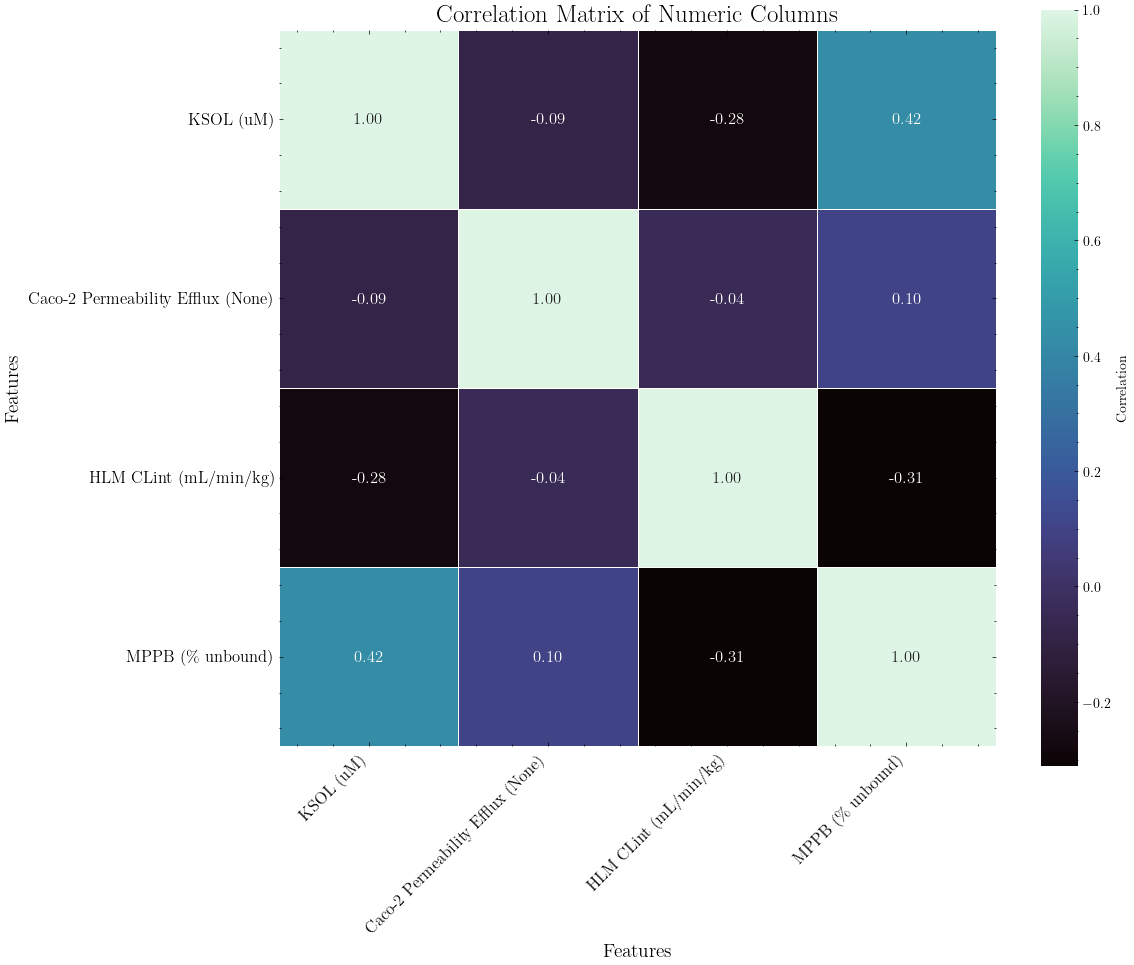

In [27]:
df = df_kermt_biogen_admet_cleaned.copy()
fname = "kermt_biogen_admet_cleaned"

df_props = compute_molecular_properties(df["SMILES"])
output_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plot_numeric_distributions(
    df,
    n_cols=3,
    title="KERMT Biogen ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)


### PharmaBench

In [28]:
files_pharmabench: Dict[str, str] = {
    "LogD": "PharmaBench/final_datasets/logd_reg_final_data.csv",
    "KSOL": "PharmaBench/final_datasets/water_sol_reg_final_data.csv",  # log_10(nM)
    "HLM CLint": "PharmaBench/final_datasets/hum_mic_cl_reg_final_data.csv",  # log10(mL/min/g)
    "MLM CLint": "PharmaBench/final_datasets/mou_mic_cl_reg_final_data.csv",  # log10(mL/min/g)
    "MPPB": "PharmaBench/final_datasets/ppb_reg_final_data.csv", # %
}

smiles_col = "Smiles_unify"
target_col = "value"

df_pharmabench_admet_cleaned = pd.DataFrame()
for admet_property, file_path in files_pharmabench.items():
    logger.info(f"Processing PharmaBench ADMET property: {admet_property}")
    data_path = base_data_dir / file_path
    df_property = pd.read_csv(data_path)

    # drop rows with invalid SMILES
    df_property[smiles_col] = parallel_canonicalize_smiles(
        df_property[smiles_col].tolist(),
        isomeric=True,
    )
    n_none_smiles = df_property[smiles_col].isnull().sum()
    if n_none_smiles > 0:
        logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES for property {admet_property}")
        df_property.dropna(subset=[smiles_col], inplace=True)
        df_property.reset_index(drop=True, inplace=True)

    logger.info(f"PharmaBench Dataframe for {admet_property} shape: {df_property.shape}")
    logger.info(f"PharmaBench Dataframe for {admet_property} columns: {df_property.columns.tolist()}")

    df_property_admet_cleaned = df_property[[smiles_col, target_col]].copy()
    if admet_property == "KSOL":
        output_col = f"{admet_property} (uM)"
        df_property_admet_cleaned[output_col] = df_property_admet_cleaned[target_col].apply(TRANSFORMATIONS["10^(x)"]).apply(TRANSFORMATIONS["nM to uM"])
    elif admet_property in ["MLM CLint", "HLM CLint"]:
        output_col = f"{admet_property} (mL/min/kg)"
        df_property_admet_cleaned[output_col] = df_property_admet_cleaned[target_col].apply(TRANSFORMATIONS["10^(x)"]) # .apply(TRANSFORMATIONS["kg to g"])
    elif admet_property == "LogD":
        output_col = f"{admet_property} (None)"
        df_property_admet_cleaned[output_col] = df_property_admet_cleaned[target_col].apply(TRANSFORMATIONS["None"])
    elif admet_property == "MPPB":
        output_col = f"{admet_property} (% unbound)"
        df_property_admet_cleaned[output_col] = df_property_admet_cleaned[target_col].apply(TRANSFORMATIONS["None"])
    else:
        raise ValueError(f"Unknown ADMET property: {admet_property}")
    
    df_property_admet_cleaned.rename(columns={smiles_col: "SMILES"}, inplace=True)
    df_property_admet_cleaned.drop(columns=[target_col], inplace=True)
    logger.info(f"Transformed column '{target_col}' to '{output_col}' with {len(df_property_admet_cleaned)} entries.")
    if df_pharmabench_admet_cleaned.empty:
        df_pharmabench_admet_cleaned = df_property_admet_cleaned
    else:
        df_pharmabench_admet_cleaned = pd.merge(
            df_pharmabench_admet_cleaned,
            df_property_admet_cleaned,
            on="SMILES",
            how="outer",
        )
logger.info(f"PharmaBench-ExpansionRX Dataframe shape: {df_pharmabench_admet_cleaned.shape}")
logger.info(f"PharmaBench-ExpansionRX Dataframe columns: {df_pharmabench_admet_cleaned.columns.tolist()}")

2025-11-26 08:25:56,099 - __main__ - INFO - Processing PharmaBench ADMET property: LogD


Canonicalizing SMILES:   0%|          | 0/13068 [00:00<?, ?it/s]

2025-11-26 08:26:00,099 - __main__ - INFO - PharmaBench Dataframe for LogD shape: (13068, 6)
2025-11-26 08:26:00,099 - __main__ - INFO - PharmaBench Dataframe for LogD columns: ['index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-26 08:26:00,102 - __main__ - INFO - Transformed column 'value' to 'LogD (None)' with 13068 entries.
2025-11-26 08:26:00,102 - __main__ - INFO - Processing PharmaBench ADMET property: KSOL


Canonicalizing SMILES:   0%|          | 0/11701 [00:00<?, ?it/s]

2025-11-26 08:26:03,183 - __main__ - INFO - PharmaBench Dataframe for KSOL shape: (11701, 6)
2025-11-26 08:26:03,183 - __main__ - INFO - PharmaBench Dataframe for KSOL columns: ['index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-26 08:26:03,195 - __main__ - INFO - Transformed column 'value' to 'KSOL (uM)' with 11701 entries.
2025-11-26 08:26:03,215 - __main__ - INFO - Processing PharmaBench ADMET property: HLM CLint


Canonicalizing SMILES:   0%|          | 0/2286 [00:00<?, ?it/s]

2025-11-26 08:26:03,868 - __main__ - INFO - PharmaBench Dataframe for HLM CLint shape: (2286, 7)
2025-11-26 08:26:03,868 - __main__ - INFO - PharmaBench Dataframe for HLM CLint columns: ['Unnamed: 0', 'index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-26 08:26:03,871 - __main__ - INFO - Transformed column 'value' to 'HLM CLint (mL/min/kg)' with 2286 entries.
2025-11-26 08:26:03,892 - __main__ - INFO - Processing PharmaBench ADMET property: MLM CLint


Canonicalizing SMILES:   0%|          | 0/1403 [00:00<?, ?it/s]

2025-11-26 08:26:04,273 - __main__ - INFO - PharmaBench Dataframe for MLM CLint shape: (1403, 7)
2025-11-26 08:26:04,274 - __main__ - INFO - PharmaBench Dataframe for MLM CLint columns: ['Unnamed: 0', 'index', 'Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-26 08:26:04,276 - __main__ - INFO - Transformed column 'value' to 'MLM CLint (mL/min/kg)' with 1403 entries.
2025-11-26 08:26:04,294 - __main__ - INFO - Processing PharmaBench ADMET property: MPPB


Canonicalizing SMILES:   0%|          | 0/1262 [00:00<?, ?it/s]

2025-11-26 08:26:04,676 - __main__ - INFO - PharmaBench Dataframe for MPPB shape: (1262, 5)
2025-11-26 08:26:04,676 - __main__ - INFO - PharmaBench Dataframe for MPPB columns: ['Smiles_unify', 'value', 'property', 'scaffold_train_test_label', 'random_train_test_label']
2025-11-26 08:26:04,677 - __main__ - INFO - Transformed column 'value' to 'MPPB (% unbound)' with 1262 entries.
2025-11-26 08:26:04,698 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape: (27611, 6)
2025-11-26 08:26:04,698 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe columns: ['SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'MPPB (% unbound)']


In [29]:
# drop rows with invalid SMILES
df_pharmabench_admet_cleaned["SMILES"] = parallel_canonicalize_smiles(
    df_pharmabench_admet_cleaned["SMILES"].tolist(),
    isomeric=True,
)

n_none_smiles = df_pharmabench_admet_cleaned["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_pharmabench_admet_cleaned.dropna(subset=["SMILES"], inplace=True)
    df_pharmabench_admet_cleaned.reset_index(drop=True, inplace=True)
logger.info(f"PharmaBench-ExpansionRX Dataframe shape after cleaning: {df_pharmabench_admet_cleaned.shape}")


Canonicalizing SMILES:   0%|          | 0/27611 [00:00<?, ?it/s]

2025-11-26 08:26:12,773 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after cleaning: (27611, 6)


In [30]:
# log10 transform all targets except LogD
for col in df_pharmabench_admet_cleaned.columns:
    if col in ["LogD (None)", "SMILES"]:
        continue
    else:
        logger.info(f"Log10 transforming column: {col}")
        df_pharmabench_admet_cleaned[col] = df_pharmabench_admet_cleaned[col].apply(TRANSFORMATIONS["log10(x)"])
        logger.info(f"Transformed column: {col} with log10")
        
    

2025-11-26 08:26:12,836 - __main__ - INFO - Log10 transforming column: KSOL (uM)
2025-11-26 08:26:12,855 - __main__ - INFO - Transformed column: KSOL (uM) with log10
2025-11-26 08:26:12,856 - __main__ - INFO - Log10 transforming column: HLM CLint (mL/min/kg)
2025-11-26 08:26:12,875 - __main__ - INFO - Transformed column: HLM CLint (mL/min/kg) with log10
2025-11-26 08:26:12,875 - __main__ - INFO - Log10 transforming column: MLM CLint (mL/min/kg)
2025-11-26 08:26:12,894 - __main__ - INFO - Transformed column: MLM CLint (mL/min/kg) with log10
2025-11-26 08:26:12,894 - __main__ - INFO - Log10 transforming column: MPPB (% unbound)
2025-11-26 08:26:12,913 - __main__ - INFO - Transformed column: MPPB (% unbound) with log10


In [31]:
# compute molecular properties
df_props = compute_molecular_properties(df_pharmabench_admet_cleaned["SMILES"])

# drop rows with MW > 1000
idx_high_mw = df_props["MW"] > 1000.0
if idx_high_mw.sum() > 0:
    logger.warning(f"Dropping {idx_high_mw.sum()} rows with MW > 1000 g/mol")
    df_pharmabench_admet_cleaned = df_pharmabench_admet_cleaned[~idx_high_mw].reset_index(drop=True)
    logger.info(f"PharmaBench-ExpansionRX Dataframe shape after dropping high MW: {df_pharmabench_admet_cleaned.shape}")
df_props = df_props.loc[df_pharmabench_admet_cleaned.index].reset_index(drop=True)

# drop rows with -2 < LogP < 8
idx_invalid_logp = (df_props["LogP"] < -2.0) | (df_props["LogP"] > 8.0)
if idx_invalid_logp.sum() > 0:
    logger.warning(f"Dropping {idx_invalid_logp.sum()} rows with invalid LogP values")
    df_pharmabench_admet_cleaned = df_pharmabench_admet_cleaned[~idx_invalid_logp].reset_index(drop=True)
    logger.info(f"PharmaBench-ExpansionRX Dataframe shape after dropping invalid LogP: {df_pharmabench_admet_cleaned.shape}")
df_props = df_props.loc[df_pharmabench_admet_cleaned.index].reset_index(drop=True)

# drop rows with rotatable bonds > 20
idx_too_many_rot_bonds = df_props["RotBonds"] > 20
if idx_too_many_rot_bonds.sum() > 0:
    logger.warning(f"Dropping {idx_too_many_rot_bonds.sum()} rows with too many rotatable bonds")
    df_pharmabench_admet_cleaned = df_pharmabench_admet_cleaned[~idx_too_many_rot_bonds].reset_index(drop=True)
    logger.info(f"PharmaBench-ExpansionRX Dataframe shape after dropping too many rotatable bonds: {df_pharmabench_admet_cleaned.shape}")
df_props = df_props.loc[df_pharmabench_admet_cleaned.index].reset_index(drop=True)

2025-11-26 08:26:23,783 - __main__ - WARNING - Dropping 82 rows with MW > 1000 g/mol
2025-11-26 08:26:23,785 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after dropping high MW: (27529, 6)
2025-11-26 08:26:23,787 - __main__ - WARNING - Dropping 277 rows with invalid LogP values
2025-11-26 08:26:23,788 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after dropping invalid LogP: (27252, 6)
2025-11-26 08:26:23,790 - __main__ - WARNING - Dropping 120 rows with too many rotatable bonds
2025-11-26 08:26:23,791 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape after dropping too many rotatable bonds: (27132, 6)


In [32]:
# export data
logger.info(f"PharmaBench-ExpansionRX Dataframe shape: {df_pharmabench_admet_cleaned.shape}")
cleaned_data["pharmabench"] = df_pharmabench_admet_cleaned.copy()

2025-11-26 08:26:24,118 - __main__ - INFO - PharmaBench-ExpansionRX Dataframe shape: (27132, 6)


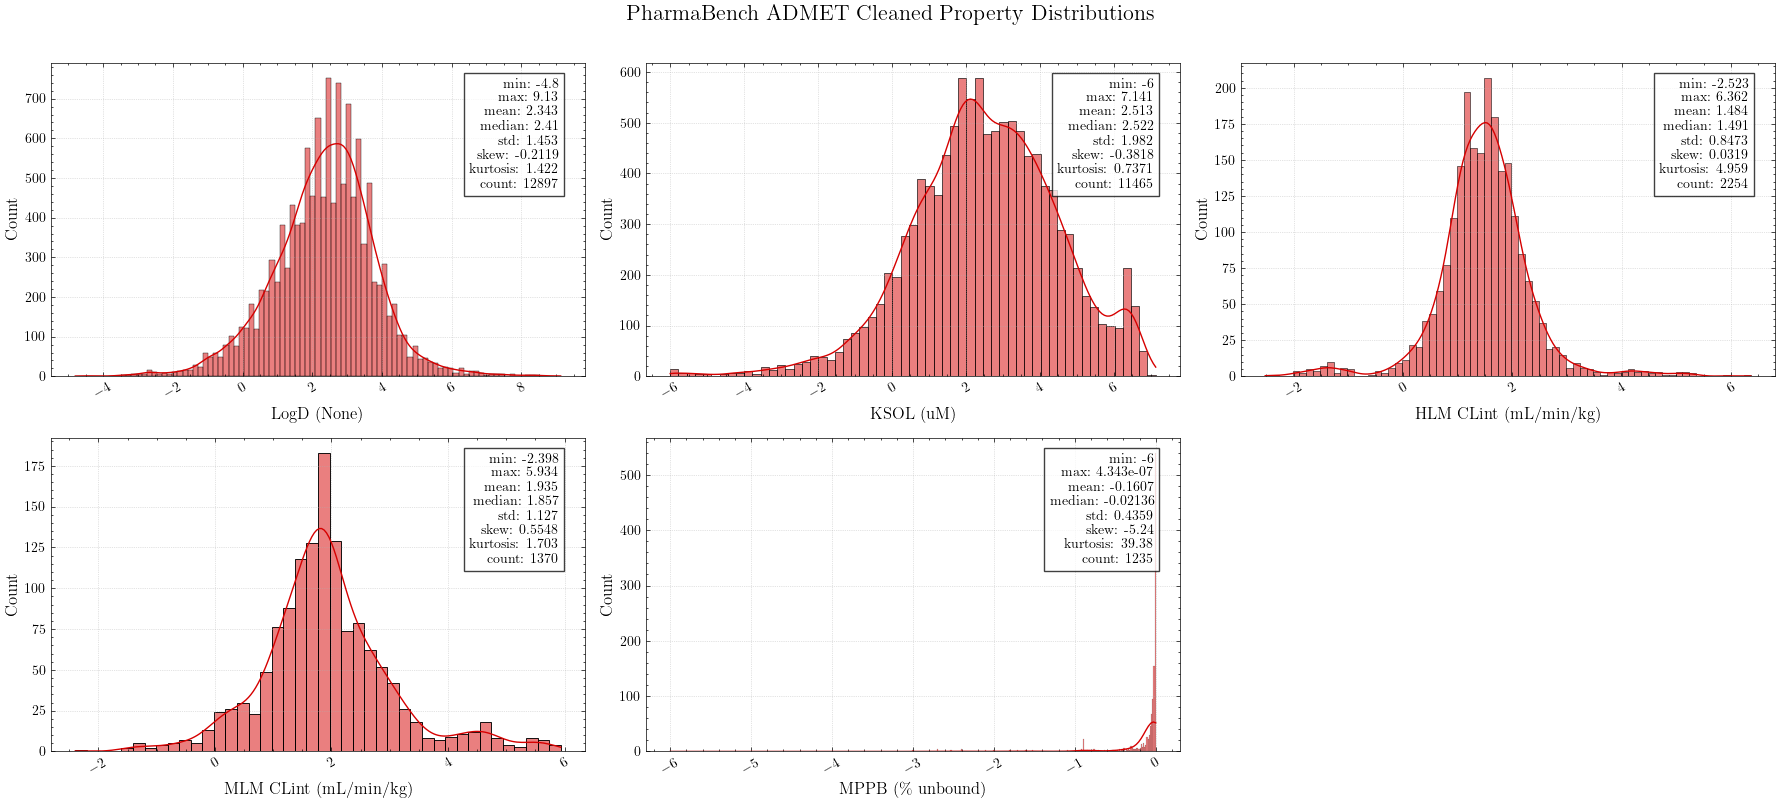

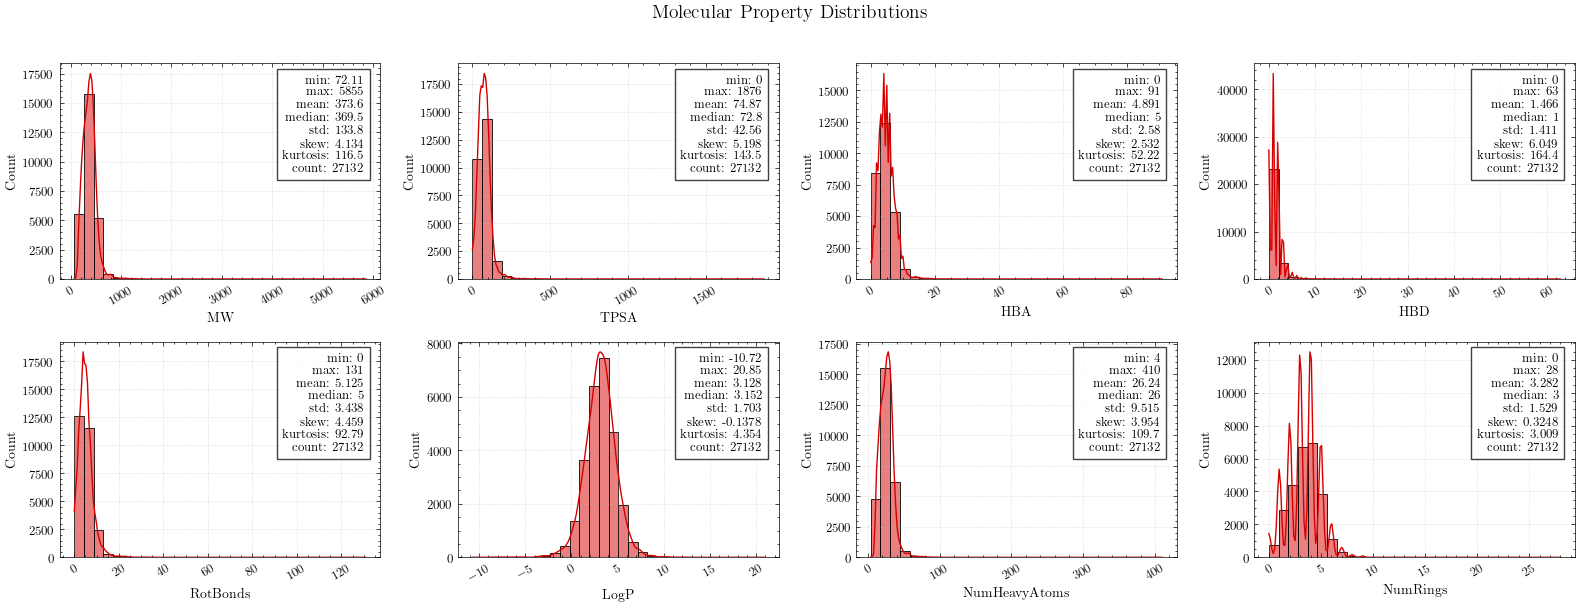

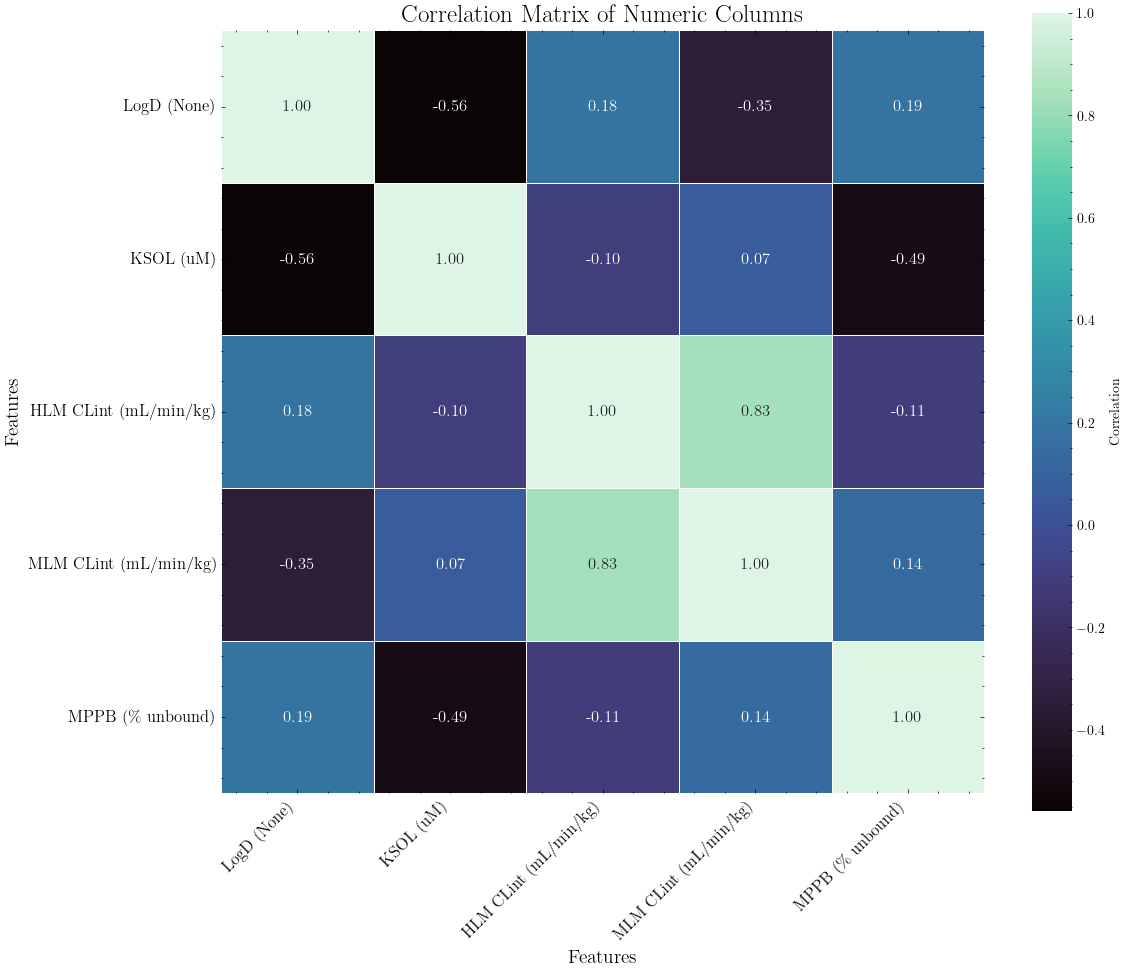

In [33]:
df = df_pharmabench_admet_cleaned.copy()
fname = "pharmabench_admet_cleaned"

output_dir.mkdir(parents=True, exist_ok=True)

fig, ax = plot_numeric_distributions(
    df,
    n_cols=3,
    title="PharmaBench ADMET Cleaned Property Distributions",
    save_path=output_dir / f"{fname}_numeric_distributions.png",
)
fig, ax = plot_property_distributions(
    df_props,
    save_path=output_dir / f"{fname}_molecular_property_distributions.png",
)
fig, ax = plot_correlation_matrix(
    df,
    save_path=output_dir / f"{fname}_numeric_correlation_matrix.png",
)

### Admetica

In [34]:
# REVIEW: Consider adding this dataset later

### TDC

In [35]:
# TODO: Implement loading and processing

### NCATS

In [36]:
# REVIEW: Consider adding this dataset later

### ChEMBL

In [37]:
# REVIEW: Consider adding this dataset later

## Final

In [38]:
# Save all cleaned datasets as a single dataframe with column for dataset name
df_out = pd.DataFrame()
for name, df in cleaned_data.items():
    logger.info(f"Adding cleaned dataset '{name}' with shape {df.shape} to combined dataframe")
    df_temp = df.copy()
    df_temp["dataset"] = name
    df_out = pd.concat([df_out, df_temp], axis=0)
logger.info(f"Combined cleaned dataframe shape: {df_out.shape}")
logger.info(f"Combined cleaned dataframe columns: {df_out.columns.tolist()}")
df_out.reset_index(drop=True, inplace=True)

2025-11-26 08:26:30,027 - __main__ - INFO - Adding cleaned dataset 'expansionrx' with shape (5326, 11) to combined dataframe
2025-11-26 08:26:30,028 - __main__ - INFO - Adding cleaned dataset 'kermt_public' with shape (114065, 8) to combined dataframe
2025-11-26 08:26:30,034 - __main__ - INFO - Adding cleaned dataset 'kermt_biogen' with shape (3521, 5) to combined dataframe
2025-11-26 08:26:30,037 - __main__ - INFO - Adding cleaned dataset 'pharmabench' with shape (27132, 6) to combined dataframe
2025-11-26 08:26:30,041 - __main__ - INFO - Combined cleaned dataframe shape: (150044, 12)
2025-11-26 08:26:30,042 - __main__ - INFO - Combined cleaned dataframe columns: ['Molecule Name (None)', 'SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)', 'MPPB (% unbound)', 'MBPB (% unbound)', 'MGMB (% unbound)', 'dataset']


In [39]:
# rename columns to match original format drop end of columns with pattern " (None)", " (uM)", etc.
df_out.rename(
    columns={col: col.split(" (")[0] for col in df_out.columns if " (" in col},
    inplace=True,
)
    
# reorder columns to have dataset first
cols = df_out.columns.tolist()
cols.remove("dataset")
cols = ["dataset"] + cols
df_out = df_out[cols]
# rename dataset to Dataset
df_out.rename(columns={"dataset": "Dataset"}, inplace=True)

logger.info("Renamed columns to original format without units.")
logger.info(f"Final cleaned dataframe shape: {df_out.shape}")
logger.info(f"Final cleaned dataframe columns: {df_out.columns.tolist()}")

df_out.to_csv(output_dir / "combined_cleaned_admet_datasets.csv", index=False)


2025-11-26 08:26:30,139 - __main__ - INFO - Renamed columns to original format without units.
2025-11-26 08:26:30,139 - __main__ - INFO - Final cleaned dataframe shape: (150044, 12)
2025-11-26 08:26:30,140 - __main__ - INFO - Final cleaned dataframe columns: ['Dataset', 'Molecule Name', 'SMILES', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB']


In [40]:
# add quality table for each dataset (row) and endpoint (column)
quality_table = pd.DataFrame()
quality_table["Dataset"] = cleaned_data.keys()

map_logd_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "medium",
    "pharmabench": "medium",
}
map_ksol_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "low",
    "pharmabench": "low",
}
map_mlm_clint_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": None,
    "pharmabench": "medium",
}
map_hlm_clint_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "low",
    "pharmabench": "medium",
}
map_caco2_permeability_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": None,
    "pharmabench": None,
}
map_caco2_efflux_quality = {
    "expansionrx": "high",
    "kermt_public": "medium",
    "kermt_biogen": "medium",
    "pharmabench": None,
}
map_mppb_quality = {
    "expansionrx": "high",
    "kermt_public": "low",
    "kermt_biogen": "medium",
    "pharmabench": "low",
}
map_mbpb_quality = {
    "expansionrx": "high",
    "kermt_public": None,
    "kermt_biogen": None,
    "pharmabench": None,
}
map_mgmb_quality = {
    "expansionrx": "high",
    "kermt_public": None,
    "kermt_biogen": None,
    "pharmabench": None,
}
for idx, row in quality_table.iterrows():
    dataset = row["Dataset"]
    quality_table.loc[idx, "LogD quality"] = map_logd_quality.get(dataset, None)
    quality_table.loc[idx, "KSOL quality"] = map_ksol_quality.get(dataset, None)
    quality_table.loc[idx, "MLM CLint quality"] = map_mlm_clint_quality.get(dataset, None)
    quality_table.loc[idx, "HLM CLint quality"] = map_hlm_clint_quality.get(dataset, None)
    quality_table.loc[idx, "Caco-2 Permeability Efflux quality"] = map_caco2_efflux_quality.get(
        dataset, None
    )
    quality_table.loc[idx, "Caco-2 Permeability Papp A>B quality"] = map_caco2_permeability_quality.get(
        dataset, None
    )
    quality_table.loc[idx, "MPPB quality"] = map_mppb_quality.get(dataset, None)
    quality_table.loc[idx, "MBPB quality"] = map_mbpb_quality.get(dataset, None)
    quality_table.loc[idx, "MGMB quality"] = map_mgmb_quality.get(dataset, None)

logger.info(f"Quality table shape: {quality_table.shape}")
logger.info(f"Quality table columns: {quality_table.columns.tolist()}")


quality_table.to_csv(output_dir / "cleaned_datasets_quality_table.csv", index=False)
quality_table

2025-11-26 08:26:30,598 - __main__ - INFO - Quality table shape: (4, 10)
2025-11-26 08:26:30,599 - __main__ - INFO - Quality table columns: ['Dataset', 'LogD quality', 'KSOL quality', 'MLM CLint quality', 'HLM CLint quality', 'Caco-2 Permeability Efflux quality', 'Caco-2 Permeability Papp A>B quality', 'MPPB quality', 'MBPB quality', 'MGMB quality']


,Dataset,LogD quality,KSOL quality,MLM CLint quality,HLM CLint quality,Caco-2 Permeability Efflux quality,Caco-2 Permeability Papp A>B quality,MPPB quality,MBPB quality,MGMB quality
0,expansionrx,high,high,high,high,high,high,high,high,high
1,kermt_public,medium,medium,medium,medium,medium,medium,low,None,None
2,kermt_biogen,medium,low,None,low,medium,None,medium,None,None
3,pharmabench,medium,low,medium,medium,None,None,low,None,None


In [41]:
# limit datasets to physically reasonable ranges
df_props = compute_molecular_properties(df_out["SMILES"])

idx_drop = df_props["MW"] > 1000.0

idx_drop |= df_props["LogP"] < -5.0
idx_drop |= df_props["LogP"] > 10.0

idx_drop |= df_props["TPSA"] > 300.0

idx_drop |= df_props["HBA"] > 20

idx_drop |= df_props["HBD"] > 10

idx_drop |= df_props["RotBonds"] > 20

idx_drop |= df_props["NumRings"] > 10

In [42]:
# remove any idx_drop that are in the ExpansionRx teaser dataset
idx_teaser = df_out["Dataset"] == "expansionrx"
idx_drop = idx_drop & ~idx_teaser
# drop entries
n_dropped = idx_drop.sum()
if n_dropped > 0:
    logger.warning(f"Dropping {n_dropped} entries from combined dataset due to unreasonable molecular properties")
    df_out = df_out.loc[~idx_drop].copy()

for name in cleaned_data.keys():
    df_subset = df_out[df_out["Dataset"] == name]

    # check for repeated SMILES inside a dataset
    n_total = len(df_subset)
    n_unique = df_subset["SMILES"].nunique()
    n_duplicates = n_total - n_unique
    if n_duplicates > 0:
        logger.warning(f"Found {n_duplicates} duplicate SMILES in combined dataset for dataset '{name}'")
        # average (skip NaNs) over duplicates
        df_subset = df_subset.groupby("SMILES", as_index=False).mean(numeric_only=True)
        # update in main dataframe
        df_out = pd.concat(
            [df_out[df_out["Dataset"] != name], df_subset],
            axis=0,
        )
        logger.info(f"Dataframe shape after averaging duplicates for dataset '{name}': {df_out.shape}")

    # look for rows where all ADMET values are NaN
    admet_cols = [col for col in df_subset.columns if col not in ["SMILES", "Dataset"]]
    n_before = len(df_out)
    df_out = df_out.dropna(subset=admet_cols, how="all")
    n_after = len(df_out)
    n_dropped_all_nan = n_before - n_after
    if n_dropped_all_nan > 0:
        logger.warning(
            f"Dropped {n_dropped_all_nan} rows with all NaN ADMET values for dataset '{name}' after averaging duplicates"
        )



2025-11-26 08:27:24,993 - __main__ - WARNING - Dropping 528 entries from combined dataset due to unreasonable molecular properties
2025-11-26 08:27:25,027 - __main__ - WARNING - Dropped 24221 rows with all NaN ADMET values for dataset 'expansionrx' after averaging duplicates


In [46]:
# look at overlap between datasets using quality-driven priority
dataset_names = list(cleaned_data.keys())
for i in range(len(dataset_names)):
    name_i = dataset_names[i]
    smiles_i = set(df_out[df_out["Dataset"] == name_i]["SMILES"].tolist())
    for j in range(i + 1, len(dataset_names)):
        name_j = dataset_names[j]
        smiles_j = set(df_out[df_out["Dataset"] == name_j]["SMILES"].tolist())
        overlap_smiles = smiles_i.intersection(smiles_j)
        n_overlap = len(overlap_smiles)
        if n_overlap > 0:
            logger.warning(f"Found {n_overlap} overlapping SMILES between datasets '{name_i}' and '{name_j}'")

# establish per-dataset priority scores from the quality table
quality_rank = {"high": 3, "medium": 2, "low": 1, None: 0}
endpoint_quality_cols = [col for col in quality_table.columns if col.endswith(" quality")]
dataset_priorities = {}
for _, row in quality_table.iterrows():
    dataset = row["Dataset"]
    priority_score = sum(quality_rank.get(row[col], 0) for col in endpoint_quality_cols)
    endpoint_scores = {col.replace(" quality", ""): quality_rank.get(row[col], 0) for col in endpoint_quality_cols}
    dataset_priorities[dataset] = {"priority_score": priority_score, "endpoint_scores": endpoint_scores}

logger.info(
    "Dataset priority scores (higher is better): %s",
    {ds: meta["priority_score"] for ds, meta in dataset_priorities.items()},
)
logger.info("Endpoint-level quality ranks per dataset: %s", dataset_priorities)

2025-11-26 08:29:10,079 - __main__ - INFO - Dataset priority scores (higher is better): {'expansionrx': 27, 'kermt_public': 13, 'kermt_biogen': 8, 'pharmabench': 8}
2025-11-26 08:29:10,080 - __main__ - INFO - Endpoint-level quality ranks per dataset: {'expansionrx': {'priority_score': 27, 'endpoint_scores': {'LogD': 3, 'KSOL': 3, 'MLM CLint': 3, 'HLM CLint': 3, 'Caco-2 Permeability Efflux': 3, 'Caco-2 Permeability Papp A>B': 3, 'MPPB': 3, 'MBPB': 3, 'MGMB': 3}}, 'kermt_public': {'priority_score': 13, 'endpoint_scores': {'LogD': 2, 'KSOL': 2, 'MLM CLint': 2, 'HLM CLint': 2, 'Caco-2 Permeability Efflux': 2, 'Caco-2 Permeability Papp A>B': 2, 'MPPB': 1, 'MBPB': 0, 'MGMB': 0}}, 'kermt_biogen': {'priority_score': 8, 'endpoint_scores': {'LogD': 2, 'KSOL': 1, 'MLM CLint': 0, 'HLM CLint': 1, 'Caco-2 Permeability Efflux': 2, 'Caco-2 Permeability Papp A>B': 0, 'MPPB': 2, 'MBPB': 0, 'MGMB': 0}}, 'pharmabench': {'priority_score': 8, 'endpoint_scores': {'LogD': 2, 'KSOL': 1, 'MLM CLint': 2, 'HLM CL

In [47]:
# Resolve duplicated SMILES across datasets by priority (high > medium > low > None),
# then by a deterministic dataset order
quality_duplicates = df_out[df_out["SMILES"].duplicated(keep=False)]
dup_smiles = quality_duplicates["SMILES"].nunique()
if dup_smiles > 0:
    logger.warning(
        f"Found {dup_smiles} duplicated SMILES across datasets before quality-based pruning"
    )

tiebreak_order = ["expansionrx", "kermt_public", "kermt_biogen", "pharmabench"]
kept_rows = []
dropped_rows = 0
for smi, group in quality_duplicates.groupby("SMILES"):
    group = group.copy()
    group["__priority"] = group["Dataset"].map(lambda ds: dataset_priorities.get(ds, {}).get("priority_score", 0))
    group["__tiebreak"] = group["Dataset"].apply(
        lambda ds: tiebreak_order.index(ds) if ds in tiebreak_order else len(tiebreak_order)
    )
    group = group.sort_values(by=["__priority", "__tiebreak"], ascending=[False, True])
    keep = group.iloc[0]
    dropped_here = len(group) - 1
    dropped_rows += dropped_here
    logger.info(
        "SMILES '%s': keeping dataset '%s' (priority %s) and dropping %s other entries",
        smi,
        keep["Dataset"],
        int(keep["__priority"]),
        dropped_here,
    )
    kept_rows.append(keep.drop(labels=["__priority", "__tiebreak"]))

if quality_duplicates.shape[0] > 0:
    unique_rows = df_out[~df_out["SMILES"].duplicated(keep=False)]
    df_out = pd.concat([unique_rows, pd.DataFrame(kept_rows)], axis=0, ignore_index=True)
    logger.info(
        f"Quality-based pruning removed {dropped_rows} duplicate rows; df_out now has shape {df_out.shape}"
    )


In [48]:
# verify no duplicate SMILES remain
n_total = len(df_out)
n_unique = df_out["SMILES"].nunique()
n_duplicates = n_total - n_unique
if n_duplicates > 0:
    logger.error(f"Found {n_duplicates} duplicate SMILES in final combined dataset after deduplication")

# save final combined cleaned dataset
df_out.reset_index(drop=True, inplace=True)
output_path = output_dir / "cleaned_combined_datasets.csv"
df_out.to_csv(output_path, index=False)
logger.info(f"Final combined cleaned dataset saved to {output_path} with shape {df_out.shape}")

2025-11-26 08:29:20,734 - __main__ - INFO - Final combined cleaned dataset saved to /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/cleaned_combined_datasets.csv with shape (119798, 12)


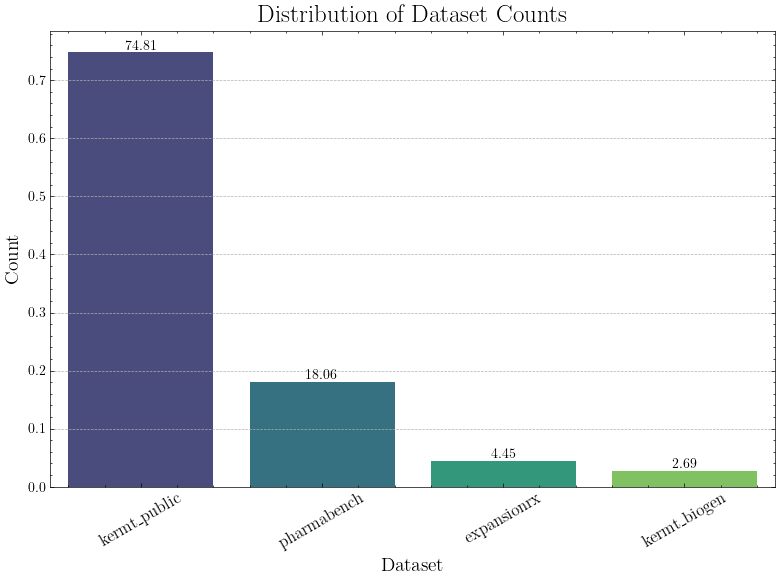

In [51]:
# plot the distribution of dataset counts
dataset_counts = df_out["Dataset"].value_counts()
# normalize counts by total number of entries
total_counts = dataset_counts.sum()
dataset_counts = dataset_counts / total_counts

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.grid(True, which="major", linestyle="--", linewidth=0.5)
sns.barplot(
    x=dataset_counts.index,
    y=dataset_counts.values,
    ax=ax,
    palette="viridis",
    hue=dataset_counts.index,
    dodge=False,
)
ax.set_xlabel("Dataset", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Distribution of Dataset Counts", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)

# add labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.2%}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=10,
    )

fig.tight_layout()
fig.savefig(output_dir / "combined_dataset_counts.png", dpi=300)

2025-11-26 08:37:22,294 - __main__ - INFO - Plotting distribution for target column 'LogD'


2025-11-26 08:37:22,775 - __main__ - DEBUG - Saved distribution plot at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/combined_LogD_distribution.png
2025-11-26 08:37:22,780 - __main__ - INFO - Plotting distribution for target column 'KSOL'
2025-11-26 08:37:23,453 - __main__ - DEBUG - Saved distribution plot at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/combined_KSOL_distribution.png
2025-11-26 08:37:23,457 - __main__ - INFO - Plotting distribution for target column 'HLM CLint'
2025-11-26 08:37:23,900 - __main__ - DEBUG - Saved distribution plot at /media/aglisman/Linux_Overflow/home/aglisman/VSCodeProjects/OpenADMET-ExpansionRx-Blind-Challenge/assets/dataset/eda/combined_HLM_CLint_distribution.png
2025-11-26 08:37:23,904 - __main__ - INFO - Plotting distribution for target column 'MLM CLint'
2025-11-26 08:37:24,570 - __main__ - DEBUG - Saved d

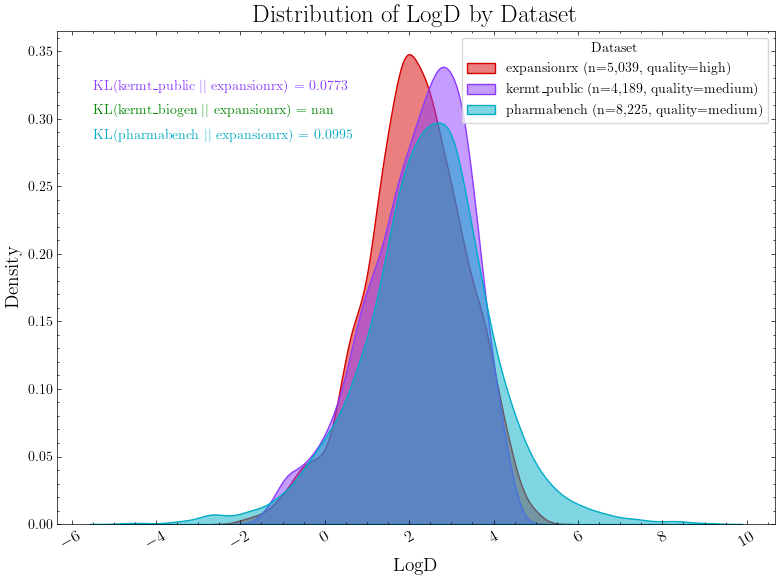

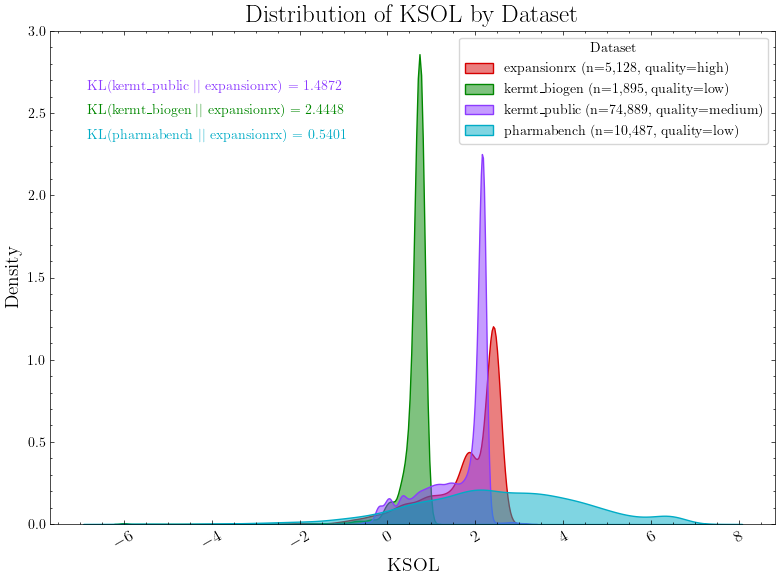

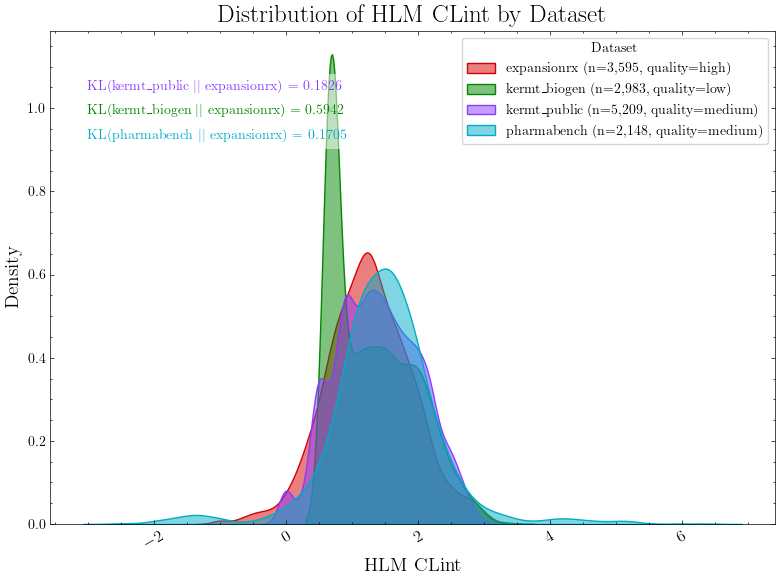

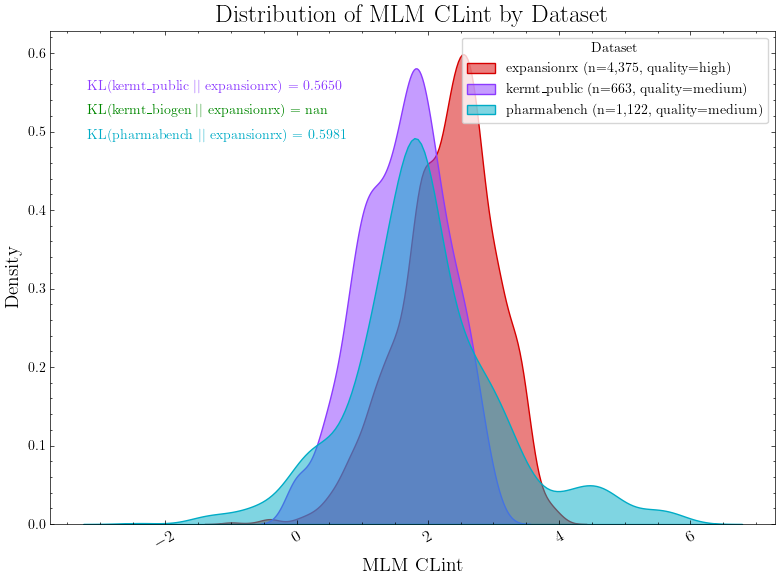

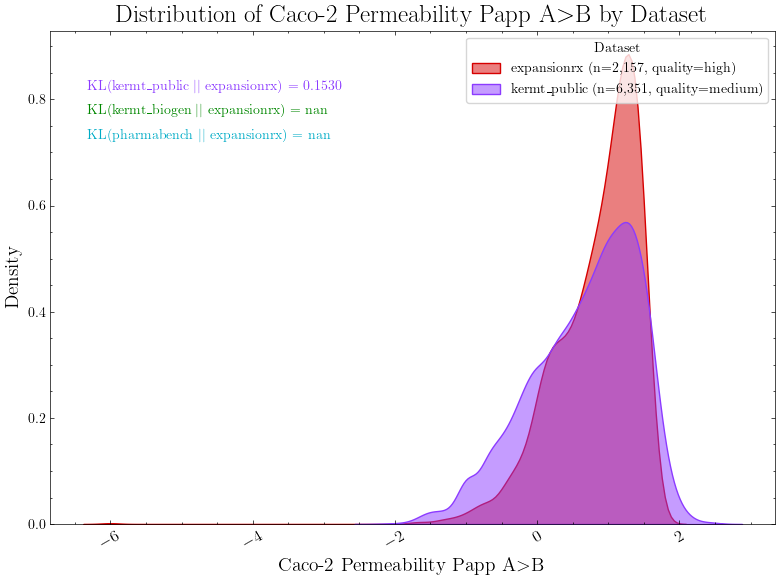

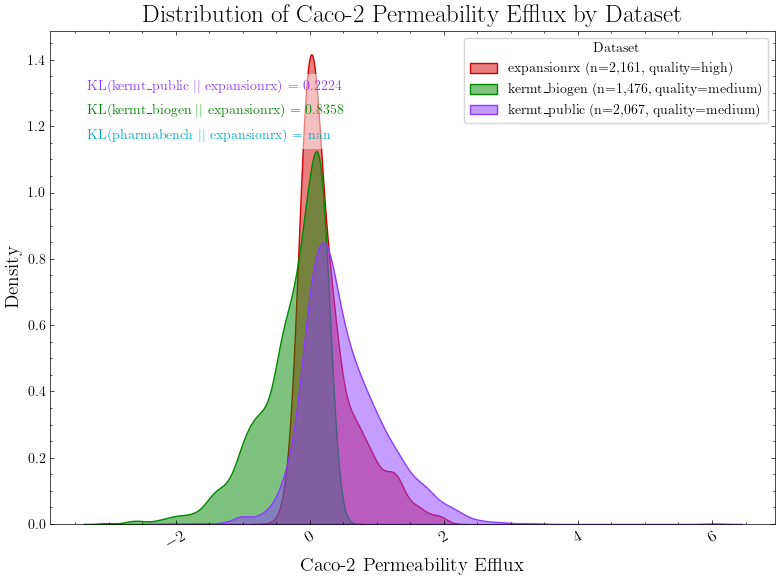

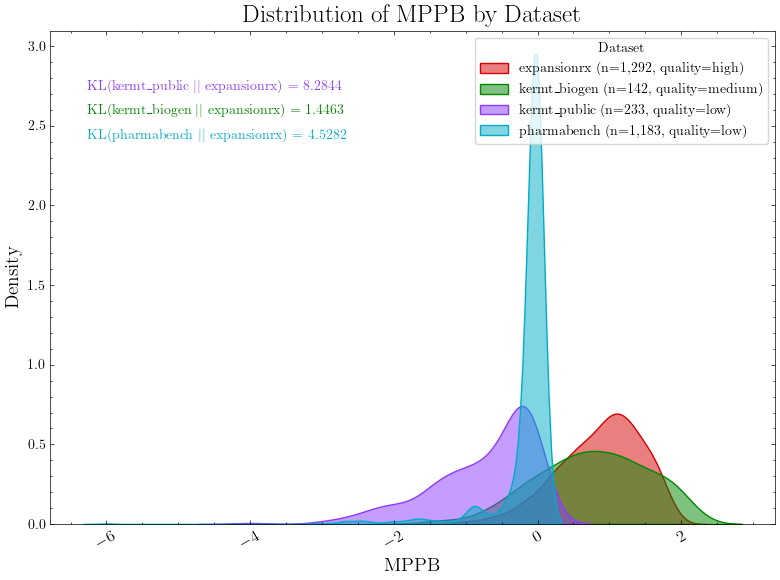

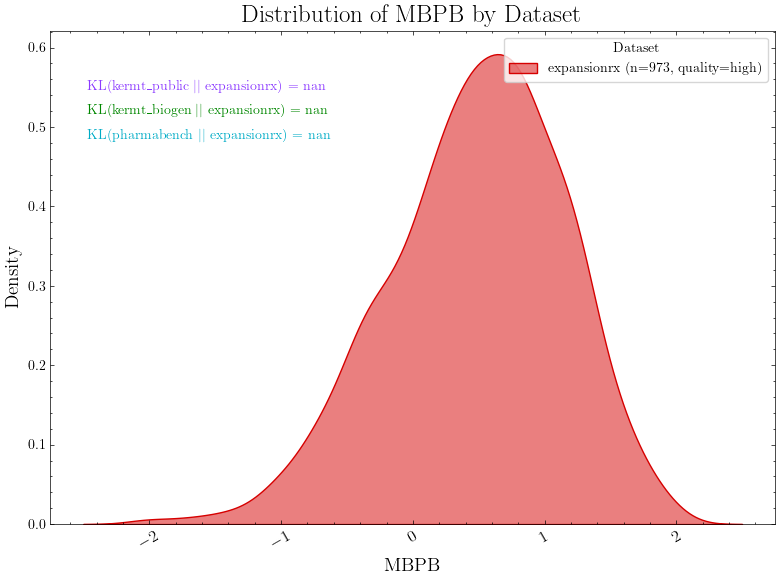

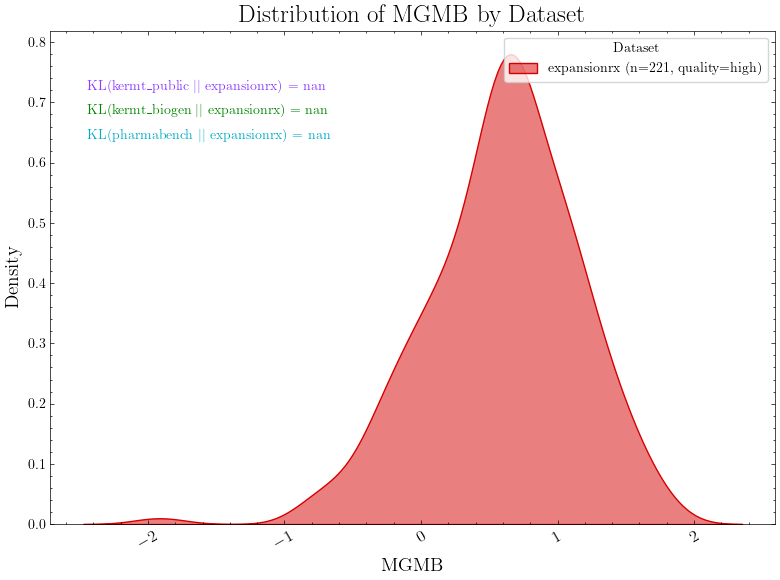

In [62]:
# plot the distribution of targets colored by dataset
target_cols = [col for col in df_out.columns if col != "SMILES" and col != "Dataset"]

colormap = cc.glasbey  # categorical colormap
dataset_to_color = {name: colormap[i] for i, name in enumerate(df_out["Dataset"].unique())}

reference_dataset = "expansionrx"

for target_col in target_cols:
    if not pd.api.types.is_numeric_dtype(df_out[target_col]):
        continue
    fig, ax = plt.subplots(figsize=(8, 6))
    logger.info(f"Plotting distribution for target column '{target_col}'")
    for dataset_name, group in df_out.groupby("Dataset"):
        sns.kdeplot(
            group[target_col].dropna(),
            ax=ax,
            label=dataset_name,
            fill=True,
            alpha=0.5,
            color=dataset_to_color[dataset_name],
        )
    ax.set_xlabel(target_col.replace('>', '$>$'), fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_title(f"Distribution of {target_col.replace('>', '$>$')} by Dataset", fontsize=18)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)

    # add KL divergence to reference dataset
    for dataset_name, group in df_out.groupby("Dataset"):
        if dataset_name == reference_dataset:
            continue
        # compute KL divergence
        data_ref = df_out[df_out["Dataset"] == reference_dataset][target_col].dropna()
        data_comp = group[target_col].dropna()
        # create histograms
        hist_ref, bin_edges = np.histogram(data_ref, bins=50, density=True)
        hist_comp, _ = np.histogram(data_comp, bins=bin_edges, density=True)
        # add small value to avoid zero entries
        hist_ref += 1e-10
        hist_comp += 1e-10
        kl_div = stats.entropy(hist_comp, hist_ref)
        ax.text(
            0.05,
            0.95 - 0.05 * list(df_out["Dataset"].unique()).index(dataset_name),
            f"KL({dataset_name} $||$ {reference_dataset}) = {kl_div:.4f}",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            color=dataset_to_color[dataset_name],
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )

    # for each dataset add number of samples to legend
    ax.legend(title="Dataset")
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        n_samples = df_out[df_out["Dataset"] == label][target_col].dropna().shape[0]
        quality = quality_table[quality_table["Dataset"] == label]
        new_labels.append(f"{label} (n={n_samples:,}, quality={quality.iloc[0][target_col + ' quality']})")
    ax.legend(handles, new_labels, title="Dataset", loc="upper right", fontsize=10, frameon=True)
    

    fig.tight_layout()

    fname_out = output_dir / f"combined_{target_col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_to_')}_distribution.png"
    fig.savefig(
        fname_out,
        dpi=300,
    )
    logger.debug(f"Saved distribution plot at {fname_out}")

2025-11-26 08:38:20,371 - __main__ - INFO - Plotting distribution for molecular property 'MW'
2025-11-26 08:38:21,112 - __main__ - INFO - Plotting distribution for molecular property 'TPSA'
2025-11-26 08:38:21,860 - __main__ - INFO - Plotting distribution for molecular property 'HBA'
2025-11-26 08:38:22,596 - __main__ - INFO - Plotting distribution for molecular property 'HBD'
2025-11-26 08:38:23,330 - __main__ - INFO - Plotting distribution for molecular property 'RotBonds'
2025-11-26 08:38:24,046 - __main__ - INFO - Plotting distribution for molecular property 'LogP'
2025-11-26 08:38:24,810 - __main__ - INFO - Plotting distribution for molecular property 'NumHeavyAtoms'
2025-11-26 08:38:25,564 - __main__ - INFO - Plotting distribution for molecular property 'NumRings'


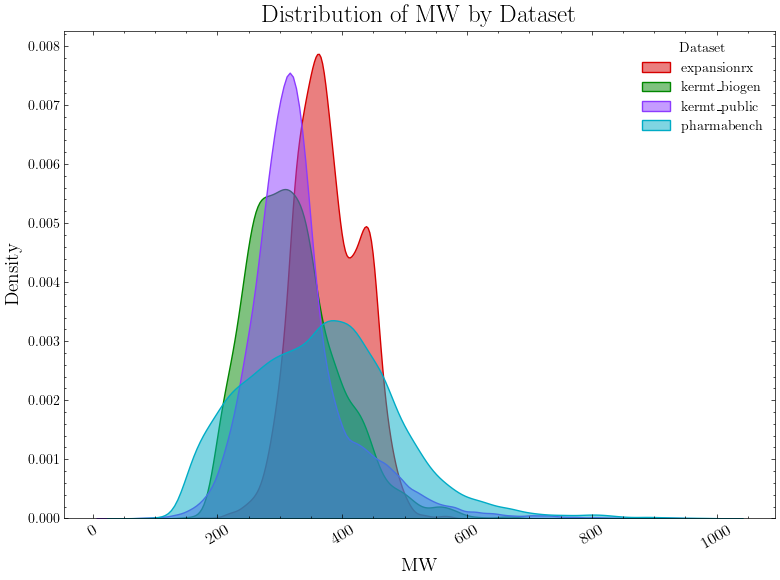

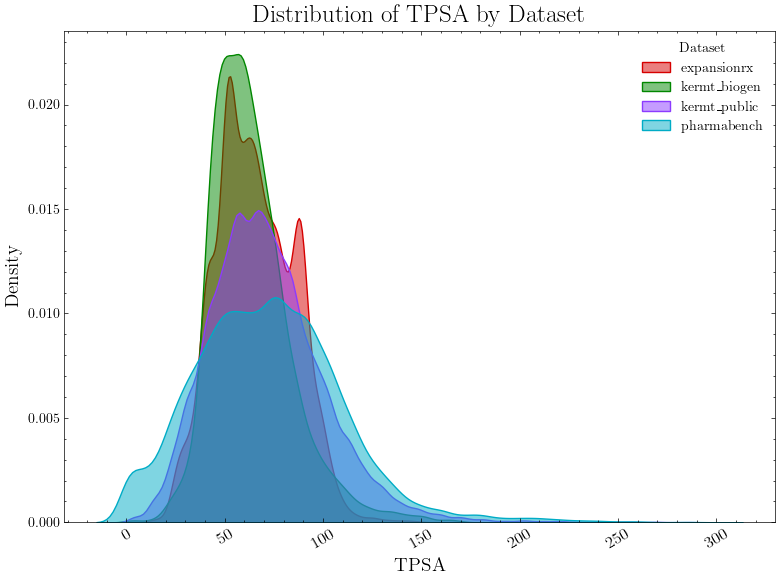

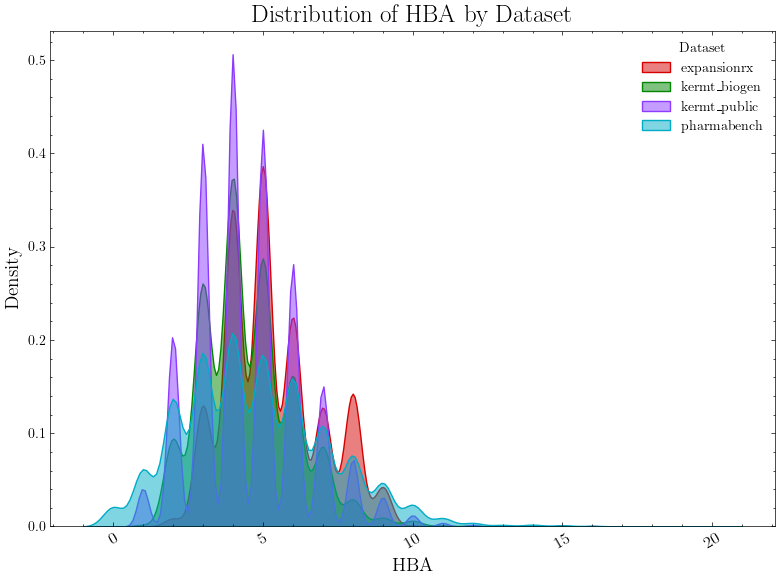

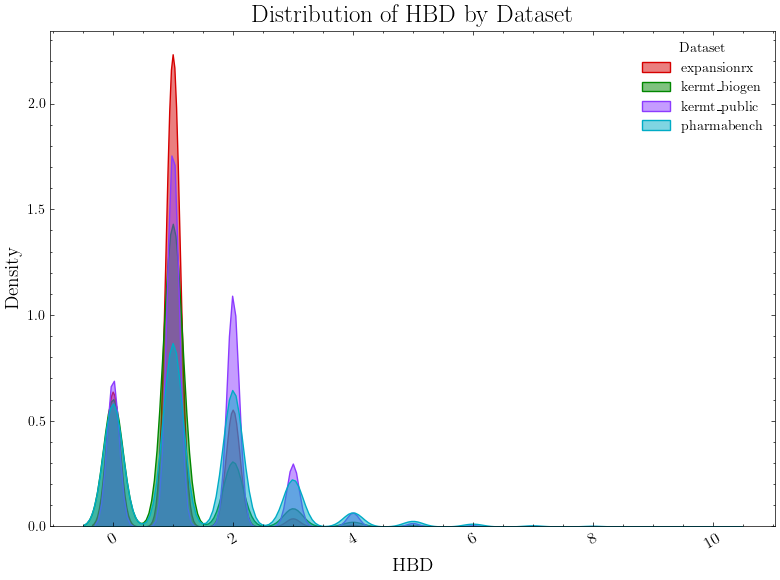

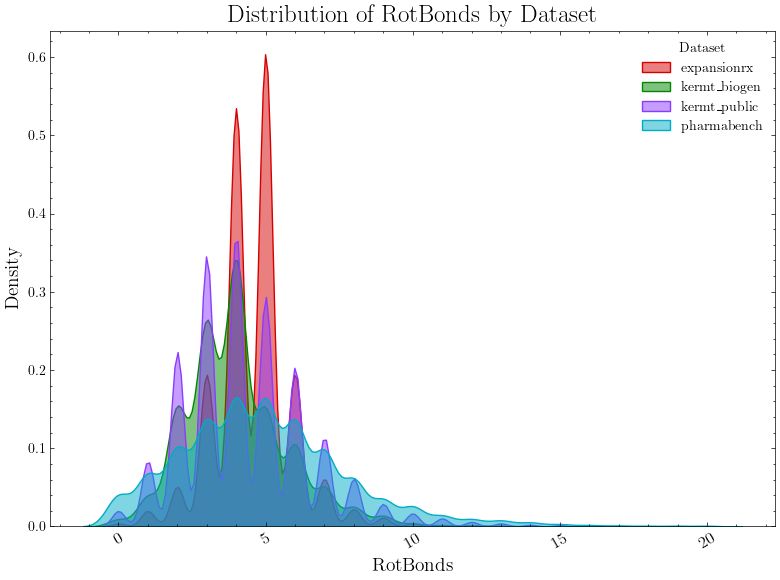

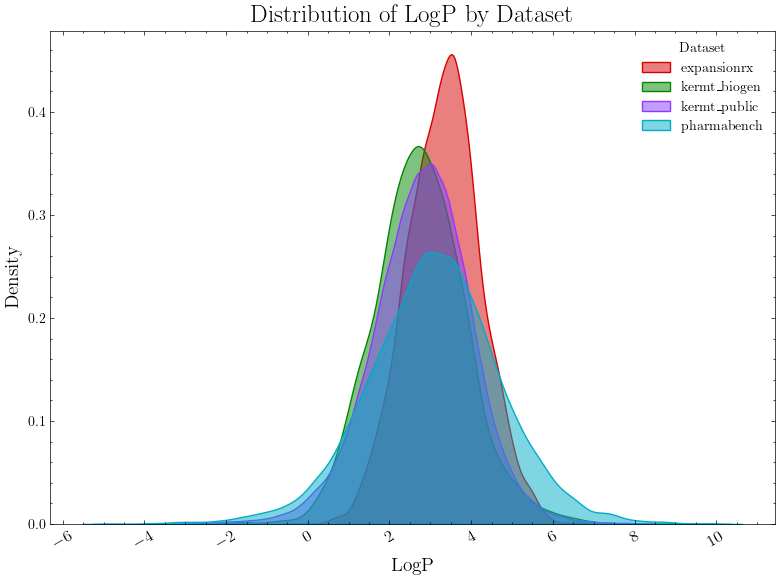

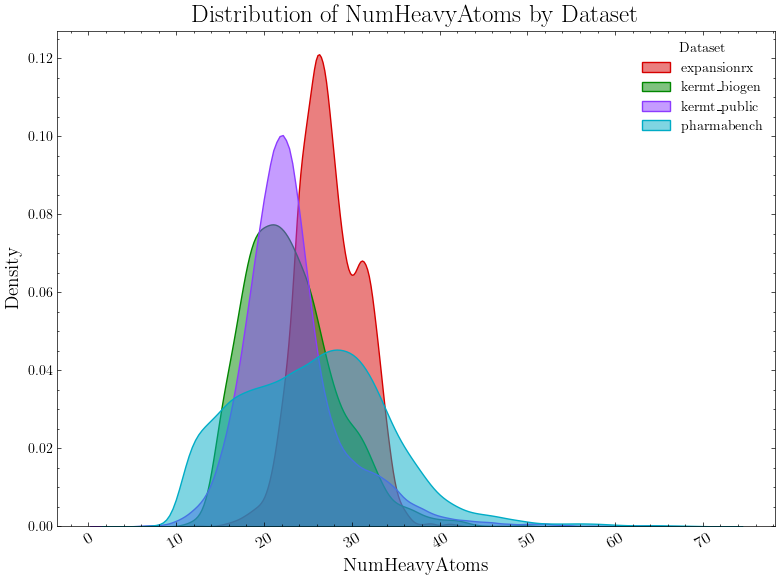

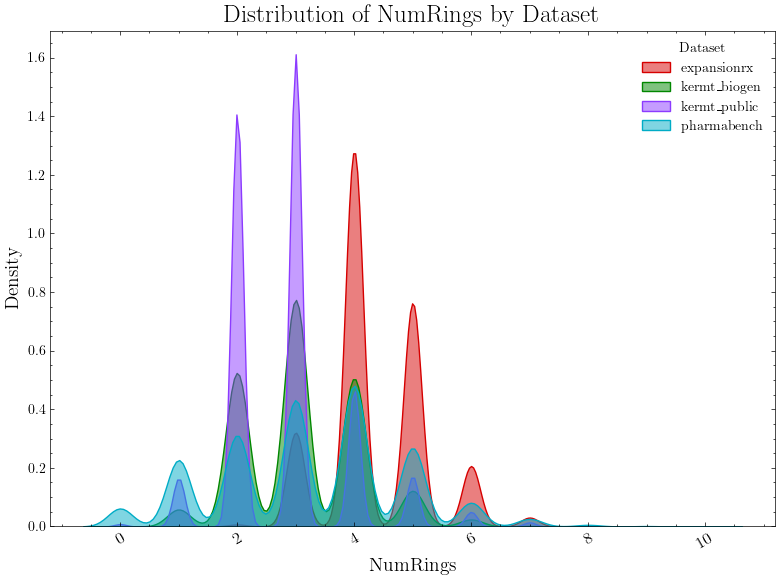

In [63]:
# plot distribution of molecular properties colored by dataset
df_props = compute_molecular_properties(df_out["SMILES"])
df_props["Dataset"] = df_out["Dataset"]
for prop_col in df_props.columns:
    if prop_col == "SMILES" or prop_col == "Dataset":
        continue
    fig, ax = plt.subplots(figsize=(8, 6))
    logger.info(f"Plotting distribution for molecular property '{prop_col}'")
    for dataset_name, group in df_props.groupby("Dataset"):
        sns.kdeplot(
            group[prop_col].dropna(),
            ax=ax,
            label=dataset_name,
            fill=True,
            alpha=0.5,
            color=dataset_to_color[dataset_name],
        )
    ax.set_xlabel(prop_col, fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_title(f"Distribution of {prop_col} by Dataset", fontsize=18)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.legend(title="Dataset")
    fig.tight_layout()
    
    fig.savefig(
        output_dir / f"combined_{prop_col.replace(' ', '_').replace('(', '').replace(')', '')}_distribution.png",
        bbox_inches="tight",
        dpi=300,
    )

In [64]:
# calculate tanimoto similarity between reference and other datasets
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
df_out["fingerprint"] = df_out["SMILES"].progress_apply(lambda smi: fpgen.GetFingerprint(Chem.MolFromSmiles(smi)))

  0%|          | 0/119798 [00:00<?, ?it/s]

2025-11-26 08:38:43,222 - __main__ - INFO - Calculating Tanimoto similarities for dataset 'kermt_biogen' against reference 'expansionrx'


Calculating Tanimoto for kermt_biogen:   0%|          | 0/3221 [00:00<?, ?it/s]

2025-11-26 08:38:44,688 - __main__ - INFO - Calculating Tanimoto similarities for dataset 'kermt_public' against reference 'expansionrx'


Calculating Tanimoto for kermt_public:   0%|          | 0/89620 [00:00<?, ?it/s]

2025-11-26 08:39:23,786 - __main__ - INFO - Calculating Tanimoto similarities for dataset 'pharmabench' against reference 'expansionrx'


Calculating Tanimoto for pharmabench:   0%|          | 0/21631 [00:00<?, ?it/s]

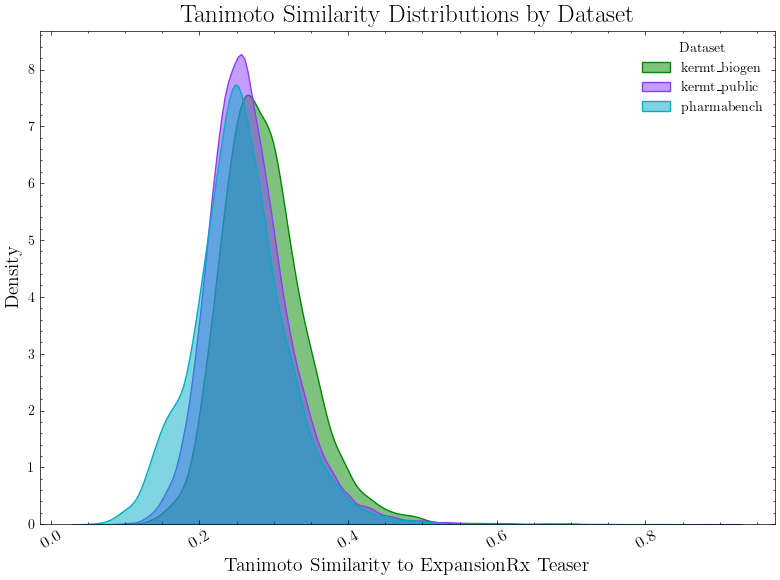

In [65]:
# plot the distribution of Tanimoto similarities to the reference set (ExpansionRx teaser)
df_reference = df_out[df_out["Dataset"] == "expansionrx"]


fig, ax = plt.subplots(figsize=(8, 6))
for dataset_name, group in df_out.groupby("Dataset"):
    if dataset_name == "expansionrx":
        continue
    logger.info(f"Calculating Tanimoto similarities for dataset '{dataset_name}' against reference 'expansionrx'")
    tanimoto_sims = []
    for fp in tqdm(group["fingerprint"], desc=f"Calculating Tanimoto for {dataset_name}"):
        sims = DataStructs.BulkTanimotoSimilarity(fp, df_reference["fingerprint"].tolist())
        max_sim = max(sims) if sims else 0.0
        tanimoto_sims.append(max_sim)
    group["Tanimoto to expansionrx"] = tanimoto_sims
    
    sns.kdeplot(
        group["Tanimoto to expansionrx"],
        ax=ax,
        label=dataset_name,
        fill=True,
        alpha=0.5,
        color=dataset_to_color[dataset_name],
    )
ax.set_xlabel("Tanimoto Similarity to ExpansionRx Teaser", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Tanimoto Similarity Distributions by Dataset", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)
ax.legend(title="Dataset")
fig.tight_layout()
fig.savefig(
    output_dir / f"combined_tanimoto_similarity_distribution.png",
    dpi=600,
)


2025-11-26 08:42:43,090 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'kermt_biogen' -> 'expansionrx'


Tanimoto kermt_biogen->expansionrx:   0%|          | 0/3221 [00:00<?, ?it/s]

2025-11-26 08:42:44,462 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'expansionrx' -> 'kermt_public'


Tanimoto expansionrx->kermt_public:   0%|          | 0/5326 [00:00<?, ?it/s]

2025-11-26 08:43:37,723 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'expansionrx' -> 'pharmabench'


Tanimoto expansionrx->pharmabench:   0%|          | 0/5326 [00:00<?, ?it/s]

2025-11-26 08:43:46,254 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'kermt_biogen' -> 'kermt_public'


Tanimoto kermt_biogen->kermt_public:   0%|          | 0/3221 [00:00<?, ?it/s]

2025-11-26 08:44:18,764 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'kermt_biogen' -> 'pharmabench'


Tanimoto kermt_biogen->pharmabench:   0%|          | 0/3221 [00:00<?, ?it/s]

2025-11-26 08:44:23,985 - __main__ - INFO - Calculating Tanimoto similarities for dataset pair 'pharmabench' -> 'kermt_public'


Tanimoto pharmabench->kermt_public:   0%|          | 0/21631 [00:00<?, ?it/s]

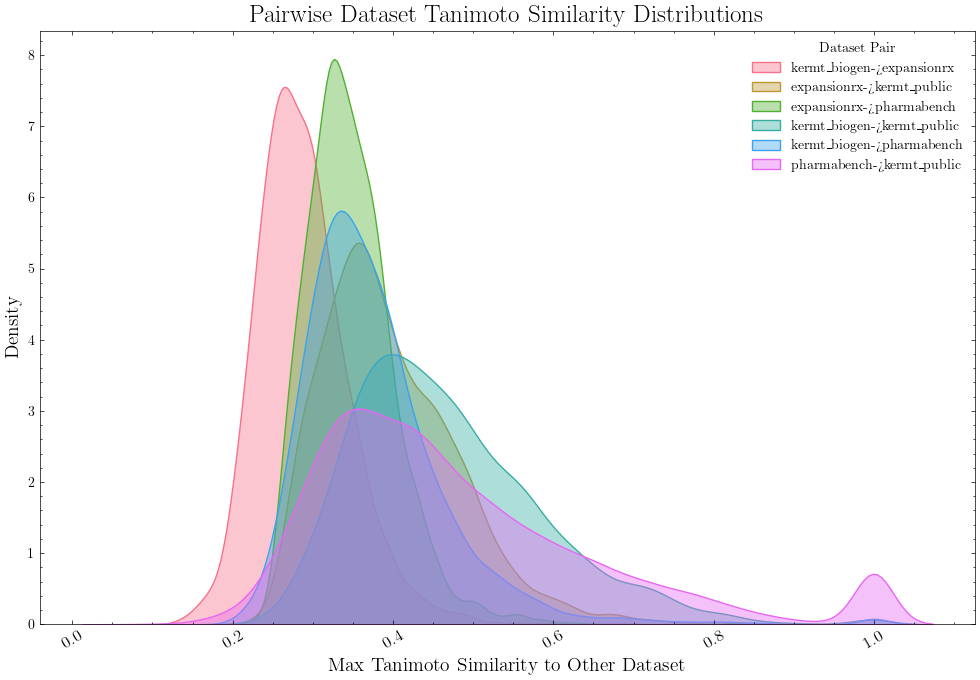

In [ ]:
# plot the distribution of Tanimoto similarities between all dataset pairs
from itertools import combinations

# precompute fingerprint lists for each dataset
dataset_fps = {name: group["fingerprint"].tolist() for name, group in df_out.groupby("Dataset")}
dataset_pairs = list(combinations(dataset_fps.keys(), 2))
pair_palette = sns.color_palette("husl", n_colors=len(dataset_pairs))

fig, ax = plt.subplots(figsize=(10, 7))
for color, (ds_a, ds_b) in zip(pair_palette, dataset_pairs):
    # compute from the smaller source dataset to reduce total comparisons
    if len(dataset_fps[ds_a]) <= len(dataset_fps[ds_b]):
        source, target = ds_a, ds_b
    else:
        source, target = ds_b, ds_a
    target_fps = dataset_fps[target]
    tanimoto_sims = []
    logger.info("Calculating Tanimoto similarities for dataset pair '%s' -> '%s'" % (source, target))
    for fp in tqdm(dataset_fps[source], desc=f"Tanimoto {source}->{target}"):
        sims = DataStructs.BulkTanimotoSimilarity(fp, target_fps) if target_fps else []
        tanimoto_sims.append(max(sims) if sims else 0.0)
    pair_label = f"{source}" + r"$\longleftrightarrow$" + f"{target}"
    sns.kdeplot(
        tanimoto_sims,
        ax=ax,
        label=pair_label,
        fill=True,
        alpha=0.4,
        color=color,
    )
ax.set_xlabel("Max Tanimoto Similarity to Other Dataset", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title("Pairwise Dataset Tanimoto Similarity Distributions", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)
ax.legend(title="Dataset Pair")
fig.tight_layout()
fig.savefig(output_dir / "pairwise_tanimoto_similarity_distribution.png", dpi=600)


## Split datasets into High, Medium, and Low Quality datasets

In [67]:
df_data = df_out.drop(columns=["fingerprint"]).copy()
logger.info(f"Final cleaned combined dataframe shape: {df_data.shape}")
logger.info(f"Final cleaned combined dataframe columns: {df_data.columns.tolist()}")

df_quality = quality_table.copy()
logger.info(f"Final quality table shape: {df_quality.shape}")
logger.info(f"Final quality table columns: {df_quality.columns.tolist()}")

2025-11-26 08:50:44,638 - __main__ - INFO - Final cleaned combined dataframe shape: (119798, 12)
2025-11-26 08:50:44,639 - __main__ - INFO - Final cleaned combined dataframe columns: ['Dataset', 'Molecule Name', 'SMILES', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB']
2025-11-26 08:50:44,639 - __main__ - INFO - Final quality table shape: (4, 10)
2025-11-26 08:50:44,640 - __main__ - INFO - Final quality table columns: ['Dataset', 'LogD quality', 'KSOL quality', 'MLM CLint quality', 'HLM CLint quality', 'Caco-2 Permeability Efflux quality', 'Caco-2 Permeability Papp A>B quality', 'MPPB quality', 'MBPB quality', 'MGMB quality']


In [68]:
start_cols = ["Molecule Name", "SMILES", "Dataset"]
endpoint_cols = [col for col in df_data.columns if col not in start_cols]

logger.info(f"Start columns: {start_cols}")
logger.info(f"Endpoint columns: {endpoint_cols}")

2025-11-26 08:50:46,531 - __main__ - INFO - Start columns: ['Molecule Name', 'SMILES', 'Dataset']
2025-11-26 08:50:46,532 - __main__ - INFO - Endpoint columns: ['LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB']


In [69]:
datasets = df_data["Dataset"].unique().tolist()
logger.info(f"Datasets in final cleaned combined dataframe: {datasets}")

2025-11-26 08:50:48,061 - __main__ - INFO - Datasets in final cleaned combined dataframe: ['expansionrx', 'kermt_public', 'kermt_biogen', 'pharmabench']


In [70]:
# make high quality subset

df_high_quality_data = df_data[start_cols].copy()
quality = "high"
for col in endpoint_cols:
    for dataset in datasets:
        # only extract columns with high quality for this dataset
        quality_col = f"{col.split(' (')[0]} quality"
        df_quality_subset = df_quality[
            (df_quality["Dataset"] == dataset) &
            (df_quality[quality_col] == quality)
        ]
        if df_quality_subset.empty:
            logger.debug(f"No high quality data for column '{col}' in dataset '{dataset}'")
            continue
        else:
            logger.info(f"Adding high quality data for column '{col}' in dataset '{dataset}'")
            df_data_subset = df_data[
                (df_data["Dataset"] == dataset) &
                (df_data[col].notna())
            ][start_cols + [col]]
            df_high_quality_data = pd.merge(
                df_high_quality_data,
                df_data_subset,
                on=start_cols,
                how="left",
            )
            # check that no suffixes were added
            if any(suffix in df_high_quality_data.columns for suffix in ["_x", "_y"]):
                logger.error(f"Suffixes '_x' or '_y' found in columns after merging high quality data for column '{col}' in dataset '{dataset}'")
                raise ValueError("Suffixes '_x' or '_y' found in columns after merging")
            
            logger.debug(f"High quality data shape after adding column '{col}' from dataset '{dataset}': {df_high_quality_data.shape}")

# drop rows with all NaN endpoints
admet_cols = [col for col in df_high_quality_data.columns if col not in start_cols]
n_before = len(df_high_quality_data)
df_high_quality_data = df_high_quality_data.dropna(subset=admet_cols, how="all")
n_after = len(df_high_quality_data)
n_dropped = n_before - n_after
if n_dropped > 0:
    logger.warning(f"Dropped {n_dropped} rows with all NaN ADMET values in high quality combined dataframe")

logger.info(f"High quality cleaned combined dataframe shape: {df_high_quality_data.shape}")

# save high quality combined cleaned dataset
df_high_quality_data.reset_index(drop=True, inplace=True)
output_path = output_dir / "cleaned_combined_datasets_high_quality.csv"
df_high_quality_data.to_csv(output_path, index=False)

2025-11-26 08:50:48,541 - __main__ - INFO - Adding high quality data for column 'LogD' in dataset 'expansionrx'
2025-11-26 08:50:48,574 - __main__ - DEBUG - High quality data shape after adding column 'LogD' from dataset 'expansionrx': (119798, 4)
2025-11-26 08:50:48,574 - __main__ - DEBUG - No high quality data for column 'LogD' in dataset 'kermt_public'
2025-11-26 08:50:48,575 - __main__ - DEBUG - No high quality data for column 'LogD' in dataset 'kermt_biogen'
2025-11-26 08:50:48,575 - __main__ - DEBUG - No high quality data for column 'LogD' in dataset 'pharmabench'
2025-11-26 08:50:48,576 - __main__ - INFO - Adding high quality data for column 'KSOL' in dataset 'expansionrx'
2025-11-26 08:50:48,607 - __main__ - DEBUG - High quality data shape after adding column 'KSOL' from dataset 'expansionrx': (119798, 5)
2025-11-26 08:50:48,608 - __main__ - DEBUG - No high quality data for column 'KSOL' in dataset 'kermt_public'
2025-11-26 08:50:48,608 - __main__ - DEBUG - No high quality data

In [71]:
# make a table of the number of data points per endpoint in the high quality dataset and percentage of total
summary_table = pd.DataFrame()
summary_table["Endpoint"] = admet_cols
n_total_entries = len(df_high_quality_data)
summary_table["Number of Data Points"] = summary_table["Endpoint"].apply(
    lambda col: df_high_quality_data[col].notna().sum()
)
summary_table["Percentage of Total"] = summary_table["Number of Data Points"].apply(
    lambda n: f"{(n / n_total_entries * 100):.2f}%"
)

# output summary table to csv
summary_table.to_csv(output_dir / "cleaned_combined_datasets_high_quality_summary_table.csv", index=False)

summary_table

,Endpoint,Number of Data Points,Percentage of Total
0,LogD,5039,94.65%
1,KSOL,5128,96.32%
2,HLM CLint,3595,67.52%
3,MLM CLint,4375,82.18%
4,Caco-2 Permeability Papp A>B,2157,40.51%
5,Caco-2 Permeability Efflux,2161,40.59%
6,MPPB,1292,24.27%
7,MBPB,973,18.28%
8,MGMB,221,4.15%


In [72]:
# assert this is the same length as the expansionrx dataset
n_expansionrx = len(df_data[df_data["Dataset"] == "expansionrx"])
n_high_quality = len(df_high_quality_data)
if n_high_quality < n_expansionrx:
    logger.error(
        f"High quality cleaned combined dataframe has fewer entries ({n_high_quality}) than ExpansionRx teaser dataset ({n_expansionrx})"
    )
elif n_high_quality == n_expansionrx:
    logger.info(
        f"High quality cleaned combined dataframe has the same number of entries ({n_high_quality}) as ExpansionRx teaser dataset ({n_expansionrx})"
    )
else:
    logger.error(
        f"High quality cleaned combined dataframe has more entries ({n_high_quality}) than ExpansionRx teaser dataset ({n_expansionrx})"
    )

2025-11-26 08:50:51,786 - __main__ - ERROR - High quality cleaned combined dataframe has fewer entries (5324) than ExpansionRx teaser dataset (5326)


In [73]:
# make medium quality subset

quality = "medium"
df_medium_quality_data = df_data[start_cols].copy()
for col in endpoint_cols:
    logger.info(f"Processing medium quality data for column '{col}'")
    df_medium_quality_data[col] = np.nan  # initialize column with NaNs
    
    for dataset in datasets:
        # only extract columns with high quality for this dataset
        quality_col = f"{col.split(' (')[0]} quality"
        df_quality_subset = df_quality[
            (df_quality["Dataset"] == dataset) & (df_quality[quality_col] == quality)
        ]
        if df_quality_subset.empty:
            #logger.debug(f"No {quality} quality data for column '{col}' in dataset '{dataset}'")
            continue
        else:
            logger.info(f"Adding {quality} quality data for column '{col}' in dataset '{dataset}'")
            
            # get smiles and values for this dataset and column
            df_data_subset = df_data[
                (df_data["Dataset"] == dataset) &
                (df_data[col].notna())
            ][["SMILES", col]]
            
            idx_update = df_medium_quality_data["SMILES"].isin(df_data_subset["SMILES"])
            n_updates = idx_update.sum()
            logger.info(f"Updating {n_updates} entries for column '{col}' from dataset '{dataset}'")
            df_medium_quality_data.loc[idx_update, col] = df_medium_quality_data.loc[idx_update, "SMILES"].map(
                df_data_subset.set_index("SMILES")[col]
            )

# drop rows with all NaN endpoints
admet_cols = [col for col in df_medium_quality_data.columns if col not in start_cols]
logger.info(f"ADMET columns in medium quality dataframe: {admet_cols}")
n_before = len(df_medium_quality_data)
df_medium_quality_data = df_medium_quality_data.dropna(subset=admet_cols, how="all")
n_after = len(df_medium_quality_data)
n_dropped = n_before - n_after
if n_dropped > 0:
    logger.warning(f"Dropped {n_dropped} rows with all NaN ADMET values in {quality} quality combined dataframe")

logger.info(f"Medium quality cleaned combined dataframe shape: {df_medium_quality_data.shape}")
logger.info(f"Medium quality cleaned combined dataframe columns: {df_medium_quality_data.columns.tolist()}")

# save medium quality combined cleaned dataset
df_medium_quality_data.reset_index(drop=True, inplace=True)
output_path = output_dir / "cleaned_combined_datasets_medium_quality.csv"
df_medium_quality_data.to_csv(output_path, index=False)


2025-11-26 08:50:52,004 - __main__ - INFO - Processing medium quality data for column 'LogD'
2025-11-26 08:50:52,005 - __main__ - INFO - Adding medium quality data for column 'LogD' in dataset 'kermt_public'
2025-11-26 08:50:52,017 - __main__ - INFO - Updating 4189 entries for column 'LogD' from dataset 'kermt_public'
2025-11-26 08:50:52,018 - __main__ - INFO - Adding medium quality data for column 'LogD' in dataset 'kermt_biogen'
2025-11-26 08:50:52,026 - __main__ - INFO - Updating 0 entries for column 'LogD' from dataset 'kermt_biogen'
2025-11-26 08:50:52,027 - __main__ - INFO - Adding medium quality data for column 'LogD' in dataset 'pharmabench'
2025-11-26 08:50:52,037 - __main__ - INFO - Updating 8225 entries for column 'LogD' from dataset 'pharmabench'
2025-11-26 08:50:52,039 - __main__ - INFO - Processing medium quality data for column 'KSOL'
2025-11-26 08:50:52,039 - __main__ - INFO - Adding medium quality data for column 'KSOL' in dataset 'kermt_public'
2025-11-26 08:50:52,055

In [74]:
# make medium quality summary table
summary_table_medium = pd.DataFrame()
summary_table_medium["Endpoint"] = admet_cols
n_total_entries_medium = len(df_medium_quality_data)
summary_table_medium["Number of Data Points"] = summary_table_medium["Endpoint"].apply(
    lambda col: df_medium_quality_data[col].notna().sum()
)
summary_table_medium["Percentage of Total"] = summary_table_medium["Number of Data Points"].apply(
    lambda n: f"{(n / n_total_entries_medium * 100):.2f}%"
)

# output medium quality summary table to csv
summary_table_medium.to_csv(
    output_dir / "cleaned_combined_datasets_medium_quality_summary_table.csv",
    index=False,
)
summary_table_medium

,Endpoint,Number of Data Points,Percentage of Total
0,LogD,12414,12.20%
1,KSOL,74889,73.61%
2,HLM CLint,7357,7.23%
3,MLM CLint,1785,1.75%
4,Caco-2 Permeability Papp A>B,6351,6.24%
5,Caco-2 Permeability Efflux,3543,3.48%
6,MPPB,142,0.14%
7,MBPB,0,0.00%
8,MGMB,0,0.00%


In [75]:
# check no overlap between high and medium quality datasets
smiles_high_quality = set(df_high_quality_data["SMILES"].tolist())
smiles_medium_quality = set(df_medium_quality_data["SMILES"].tolist())
overlap_smiles = smiles_high_quality.intersection(smiles_medium_quality)
n_overlap = len(overlap_smiles)
if n_overlap > 0:
    logger.critical(
        f"Found {n_overlap} overlapping SMILES between high and medium quality cleaned combined dataframes"
    )

# save medium+high quality combined cleaned dataset
df_medium_high_quality_data = pd.concat([df_high_quality_data, df_medium_quality_data], axis=0)
logger.info(f"Medium+High quality cleaned combined dataframe shape: {df_medium_high_quality_data.shape}")
logger.info(f"Medium+High quality cleaned combined dataframe columns: {df_medium_high_quality_data.columns.tolist()}")
df_medium_high_quality_data.reset_index(drop=True, inplace=True)
output_path = output_dir / "cleaned_combined_datasets_medium_high_quality.csv"
df_medium_high_quality_data.to_csv(output_path, index=False)

2025-11-26 08:50:52,607 - __main__ - INFO - Medium+High quality cleaned combined dataframe shape: (107059, 12)
2025-11-26 08:50:52,607 - __main__ - INFO - Medium+High quality cleaned combined dataframe columns: ['Molecule Name', 'SMILES', 'Dataset', 'LogD', 'KSOL', 'HLM CLint', 'MLM CLint', 'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 'MPPB', 'MBPB', 'MGMB']


In [76]:
# make low quality subset
df_low_quality_data = df_data[start_cols].copy()
quality = "low"

for col in endpoint_cols:
    for dataset in datasets:
        # only extract columns with high quality for this dataset
        quality_col = f"{col.split(' (')[0]} quality"
        df_quality_subset = df_quality[
            (df_quality["Dataset"] == dataset) & (df_quality[quality_col] == quality)
        ]
        if df_quality_subset.empty:
            logger.debug(f"No {quality} quality data for column '{col}' in dataset '{dataset}'")
            continue
        else:
            # get smiles and values for this dataset and column
            df_data_subset = df_data[
                (df_data["Dataset"] == dataset) &
                (df_data[col].notna())
            ][["SMILES", col]]
            
            idx_update = df_low_quality_data["SMILES"].isin(df_data_subset["SMILES"])
            n_updates = idx_update.sum()
            logger.info(f"Updating {n_updates} entries for column '{col}' from dataset '{dataset}'")
            df_low_quality_data.loc[idx_update, col] = df_low_quality_data.loc[idx_update, "SMILES"].map(
                df_data_subset.set_index("SMILES")[col]
            )
            

# drop rows with all NaN endpoints
admet_cols = [col for col in df_low_quality_data.columns if col not in start_cols]
n_before = len(df_low_quality_data)
df_low_quality_data = df_low_quality_data.dropna(subset=admet_cols, how="all")
n_after = len(df_low_quality_data)
n_dropped = n_before - n_after
if n_dropped > 0:
    logger.warning(f"Dropped {n_dropped} rows with all NaN ADMET values in {quality} quality combined dataframe")
logger.info(f"Low quality cleaned combined dataframe shape: {df_low_quality_data.shape}")

# save low quality combined cleaned dataset
df_low_quality_data.reset_index(drop=True, inplace=True)
output_path = output_dir / "cleaned_combined_datasets_low_quality.csv"
df_low_quality_data.to_csv(output_path, index=False)

# make sure no overlap between low and medium/high quality datasets
smiles_low_quality = set(df_low_quality_data["SMILES"].tolist())
smiles_medium_high_quality = set(df_medium_high_quality_data["SMILES"].tolist())
overlap_smiles = smiles_low_quality.intersection(smiles_medium_high_quality)
n_overlap = len(overlap_smiles)
if n_overlap > 0:
    logger.critical(
        f"Found {n_overlap} overlapping SMILES between low and medium/high quality cleaned combined dataframes"
    )

# output low+medium+high quality combined cleaned dataset
df_low_medium_high_quality_data = pd.concat(
    [df_low_quality_data, df_medium_high_quality_data],
    axis=0,
)
df_low_medium_high_quality_data.reset_index(drop=True, inplace=True)
logger.info(f"Low+Medium+High quality cleaned combined dataframe shape: {df_low_medium_high_quality_data.shape}")
logger.info(f"Low+Medium+High quality cleaned combined dataframe columns: {df_low_medium_high_quality_data.columns.tolist()}")
output_path = output_dir / "cleaned_combined_datasets_low_medium_high_quality.csv"
df_low_medium_high_quality_data.to_csv(output_path, index=False)

2025-11-26 08:50:52,989 - __main__ - DEBUG - No low quality data for column 'LogD' in dataset 'expansionrx'
2025-11-26 08:50:52,989 - __main__ - DEBUG - No low quality data for column 'LogD' in dataset 'kermt_public'
2025-11-26 08:50:52,990 - __main__ - DEBUG - No low quality data for column 'LogD' in dataset 'kermt_biogen'
2025-11-26 08:50:52,990 - __main__ - DEBUG - No low quality data for column 'LogD' in dataset 'pharmabench'
2025-11-26 08:50:52,990 - __main__ - DEBUG - No low quality data for column 'KSOL' in dataset 'expansionrx'
2025-11-26 08:50:52,991 - __main__ - DEBUG - No low quality data for column 'KSOL' in dataset 'kermt_public'
2025-11-26 08:50:53,002 - __main__ - INFO - Updating 1895 entries for column 'KSOL' from dataset 'kermt_biogen'
2025-11-26 08:50:53,017 - __main__ - INFO - Updating 10487 entries for column 'KSOL' from dataset 'pharmabench'
2025-11-26 08:50:53,019 - __main__ - DEBUG - No low quality data for column 'HLM CLint' in dataset 'expansionrx'
2025-11-26 0

In [77]:
# make low quality summary table
summary_table_low = pd.DataFrame()
summary_table_low["Endpoint"] = admet_cols
n_total_entries_low = len(df_low_quality_data)
summary_table_low["Number of Data Points"] = summary_table_low["Endpoint"].apply(
    lambda col: df_low_quality_data[col].notna().sum()
)
summary_table_low["Percentage of Total"] = summary_table_low["Number of Data Points"].apply(
    lambda n: f"{(n / n_total_entries_low * 100):.2f}%"
)

# output low quality summary table to csv
summary_table_low.to_csv(
    output_dir / "cleaned_combined_datasets_low_quality_summary_table.csv",
    index=False,
)
summary_table_low

,Endpoint,Number of Data Points,Percentage of Total
0,KSOL,12382,82.49%
1,HLM CLint,2983,19.87%
2,MPPB,1416,9.43%
